# IoT anomaly detection using power meter

------

## Model training phase

Load training data. And testing datasets with and without anomalies

In [1]:
import pandas
import matplotlib.pyplot as plotter
from pathlib import Path
import seaborn

In [2]:
data = Path("../data/summer_final/")
files = list(data.iterdir())

for file in files:
    print(f"Loading data from {file}")

Loading data from ../data/summer_final/summer_final_tx.csv
Loading data from ../data/summer_final/summer_final_cpu.csv
Loading data from ../data/summer_final/summer_final_voltage.csv
Loading data from ../data/summer_final/summer_final_disk.csv
Loading data from ../data/summer_final/summer_final_rx.csv
Loading data from ../data/summer_final/summer_final_power.csv


In [3]:
disk = pandas.read_csv(str(data/"summer_final_disk.csv")).drop("Unnamed: 0", axis=1)
cpu = pandas.read_csv(str(data/"summer_final_cpu.csv")).drop("Unnamed: 0", axis=1)
power = pandas.read_csv(str(data/"summer_final_power.csv")).drop("Unnamed: 0", axis=1)
tx = pandas.read_csv(str(data/"summer_final_tx.csv")).drop("Unnamed: 0", axis=1)
rx = pandas.read_csv(str(data/"summer_final_rx.csv")).drop("Unnamed: 0", axis=1)

A lot of problems in life can be solved using preprocessing. In this case, we'll try median filtering to remove noise from the power signal

Filtering power
Before filtering


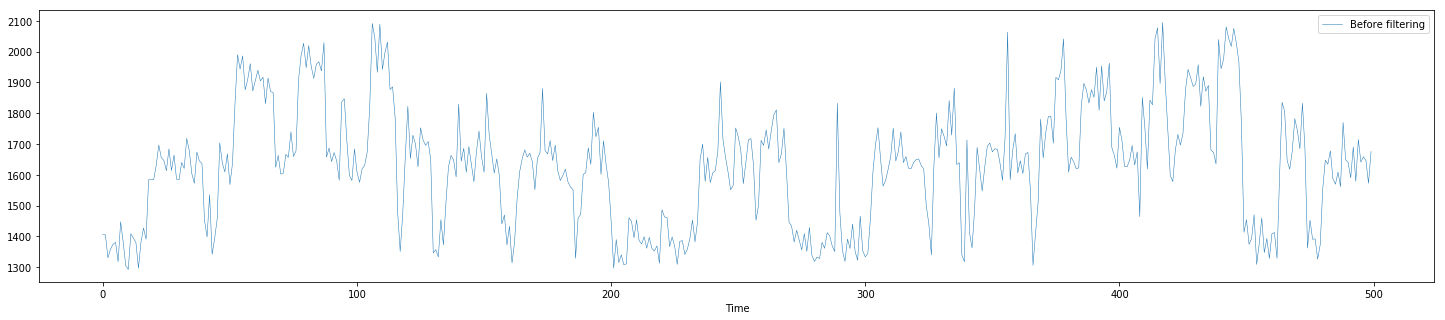

After filtering


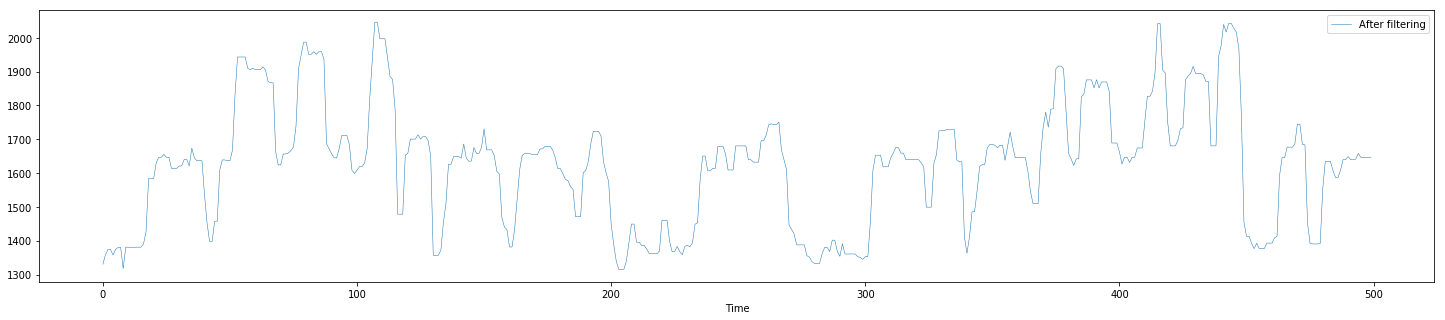

Filtering CPU
Before filtering


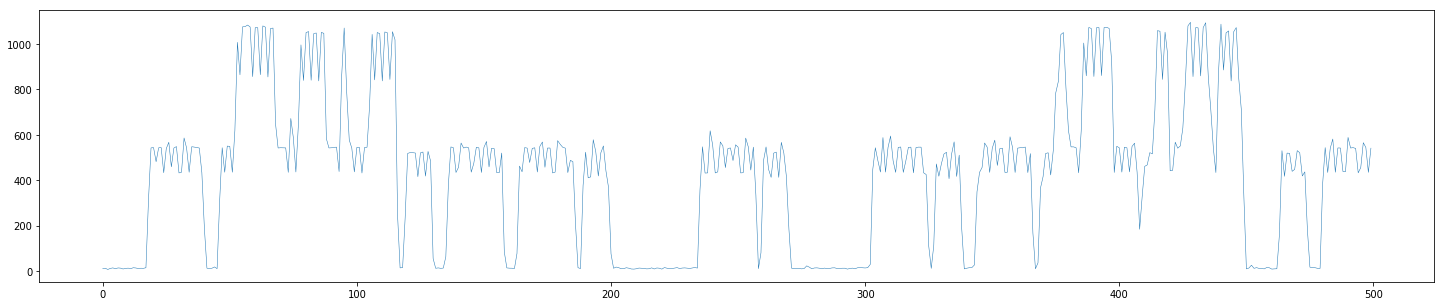

After filtering


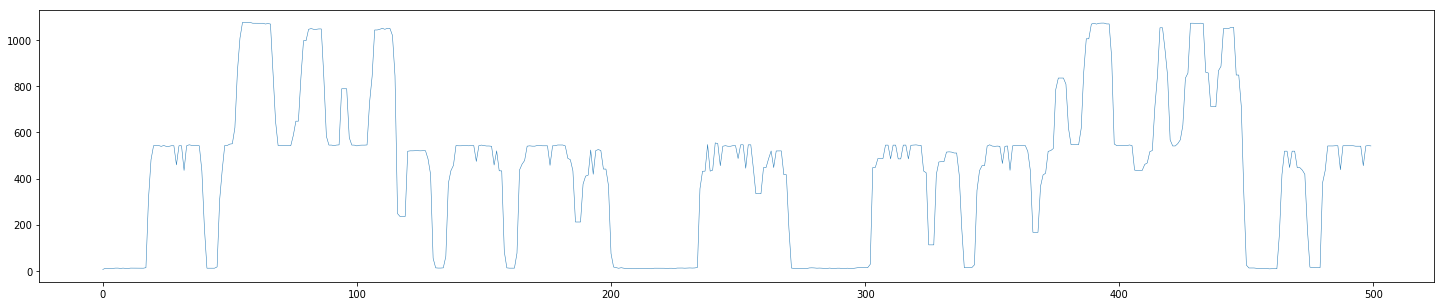

Filtering TX
Before filtering


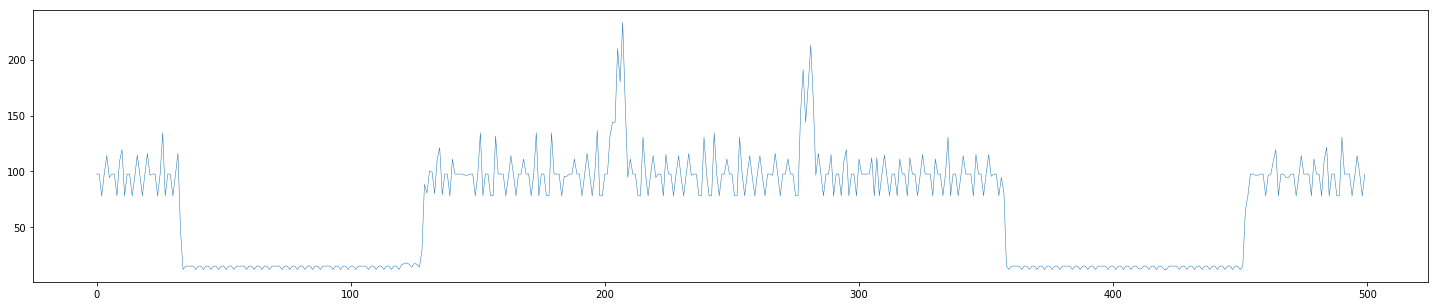

After filtering


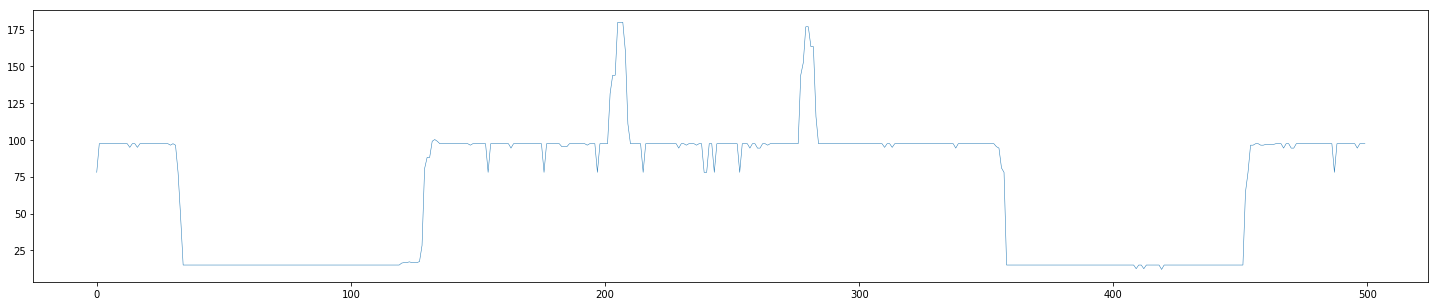

Filtering RX
Before filtering


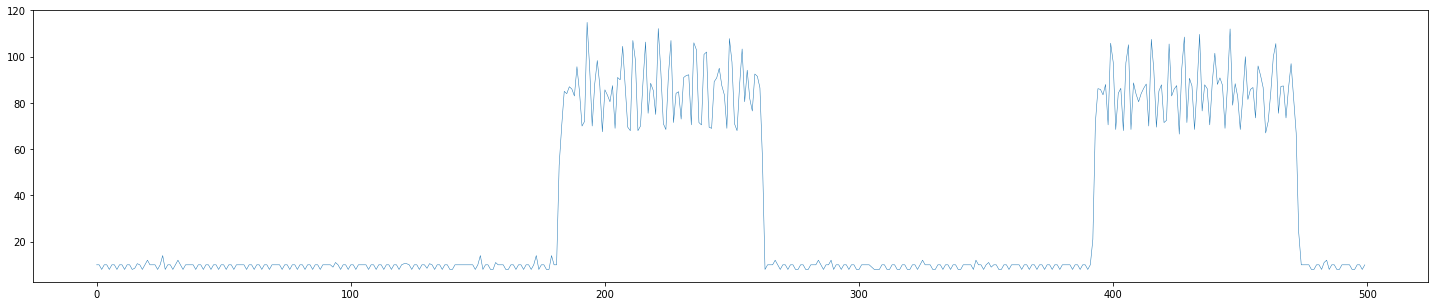

After filtering


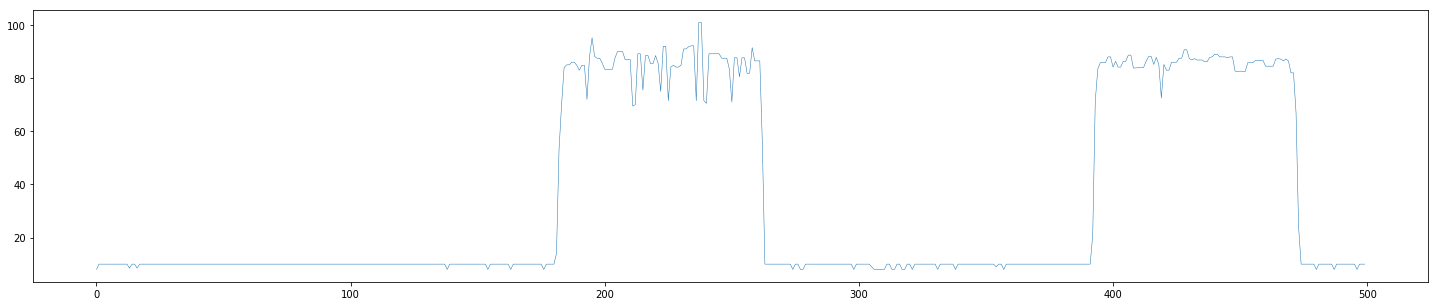

Filtering Disk
Before filtering


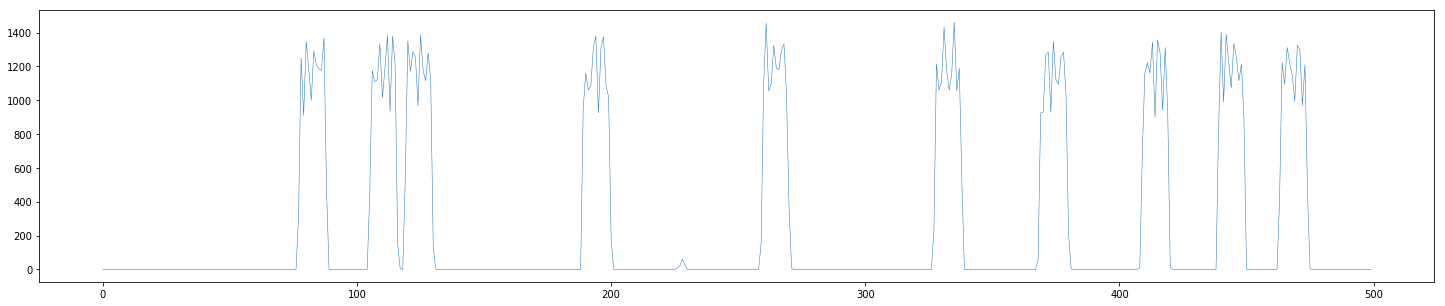

After filtering


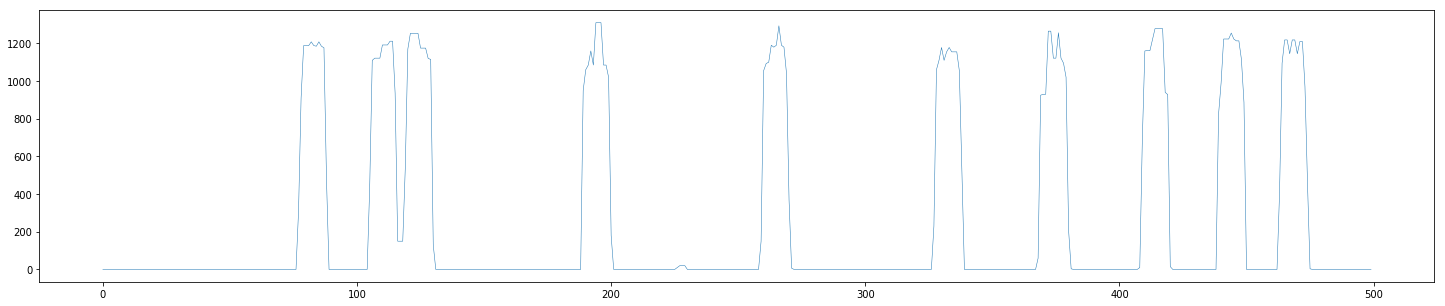

In [4]:
from scipy.signal import medfilt

print("Filtering power")
print("Before filtering")
fig = plotter.figure(figsize=(25, 5))
plotter.plot(power["Power12"].as_matrix().ravel()[0: 500], linewidth=0.5, label="Before filtering")
plotter.legend()
plotter.xlabel("Time")
plotter.savefig("before_filtering.png")
plotter.show()

print("After filtering")
power = pandas.DataFrame({"Power12": medfilt(power["Power12"].as_matrix().ravel(), kernel_size=5)})
fig = plotter.figure(figsize=(25, 5))
plotter.plot(power["Power12"].as_matrix().ravel()[0: 500], linewidth=0.5, label="After filtering")
plotter.legend()
plotter.xlabel("Time")
plotter.savefig("after_filtering.png")
plotter.show()

print("Filtering CPU")
print("Before filtering")
fig = plotter.figure(figsize=(25, 5))
plotter.plot(cpu["CPU_user"].as_matrix().ravel()[0: 500], linewidth=0.5, label="Before filtering")
plotter.show()

print("After filtering")
cpu = pandas.DataFrame({"CPU_user": medfilt(cpu["CPU_user"].as_matrix().ravel(), kernel_size=5)})
fig = plotter.figure(figsize=(25, 5))
plotter.plot(cpu["CPU_user"].as_matrix().ravel()[0: 500], linewidth=0.5, label="Before filtering")
plotter.show()

print("Filtering TX")
print("Before filtering")
fig = plotter.figure(figsize=(25, 5))
plotter.plot(tx["net_TX"].as_matrix().ravel()[0: 500], linewidth=0.5, label="Before filtering")
plotter.show()

print("After filtering")
tx = pandas.DataFrame({"net_TX": medfilt(tx["net_TX"].as_matrix().ravel(), kernel_size=5)})
fig = plotter.figure(figsize=(25, 5))
plotter.plot(tx["net_TX"].as_matrix().ravel()[0: 500], linewidth=0.5, label="Before filtering")
plotter.show()

print("Filtering RX")
print("Before filtering")
fig = plotter.figure(figsize=(25, 5))
plotter.plot(rx["net_RX"].as_matrix().ravel()[0: 500], linewidth=0.5, label="Before filtering")
plotter.show()

print("After filtering")
rx = pandas.DataFrame({"net_RX": medfilt(rx["net_RX"].as_matrix().ravel(), kernel_size=5)})
fig = plotter.figure(figsize=(25, 5))
plotter.plot(rx["net_RX"].as_matrix().ravel()[0: 500], linewidth=0.5, label="Before filtering")
plotter.show()

print("Filtering Disk")
print("Before filtering")
fig = plotter.figure(figsize=(25, 5))
plotter.plot(disk["disk_p2"].as_matrix().ravel()[0: 500], linewidth=0.5, label="Before filtering")
plotter.show()

print("After filtering")
disk = pandas.DataFrame({"disk_p2": medfilt(disk["disk_p2"].as_matrix().ravel(), kernel_size=5)})
fig = plotter.figure(figsize=(25, 5))
plotter.plot(disk["disk_p2"].as_matrix().ravel()[0: 500], linewidth=0.5, label="Before filtering")
plotter.show()

Combine all dataframes into a single dataset

In [5]:
all_data = pandas.concat([cpu, tx, disk, power.clip(lower=1200)], axis=1, join="inner").fillna(method="ffill").fillna(0)
all_data.describe()

CPU_user        net_TX       disk_p2       Power12
count  8.856000e+04  8.856000e+04  8.856000e+04  88560.000000
mean   4.160710e+02  7.739434e+01  2.218976e+02   1611.737387
std    4.914119e+05  9.459888e+04  2.734597e+05    190.917050
min   -1.034063e+08 -1.990604e+07 -5.754321e+07   1200.000000
25%    1.316667e+01  1.500000e+01  0.000000e+00   1410.975610
50%    5.050000e+02  9.750000e+01  0.000000e+00   1634.146341
75%    5.443333e+02  9.750000e+01  0.000000e+00   1712.195122
max    1.034063e+08  1.990625e+07  5.754321e+07   2197.967480

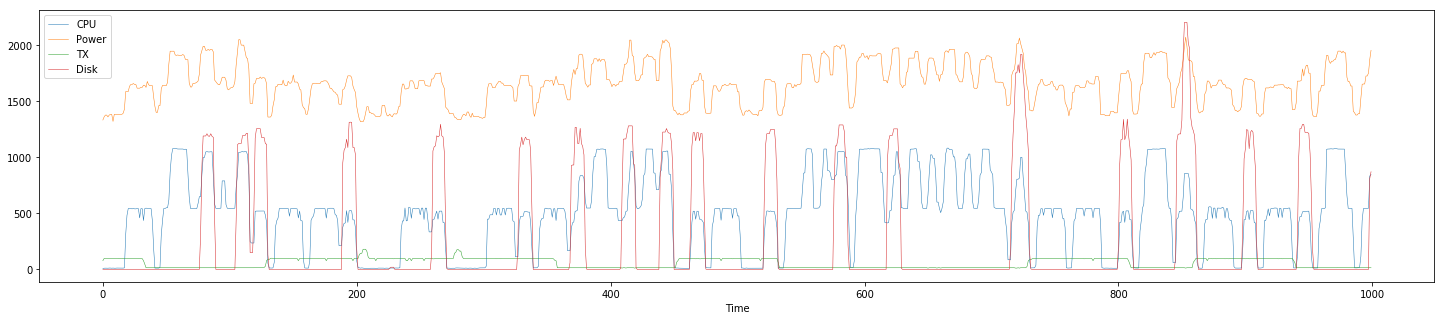

In [6]:
fig = plotter.figure(figsize=(25, 5))
plotter.plot(all_data["CPU_user"][:1000], label="CPU", linewidth=0.5)
plotter.plot(all_data["Power12"][:1000], label="Power", linewidth=0.5)
plotter.plot(all_data["net_TX"][:1000], label="TX", linewidth=0.5)
plotter.plot(all_data["disk_p2"][:1000], label="Disk", linewidth=0.5)
plotter.legend()
plotter.xlabel("Time")
plotter.savefig("all_data.png")
plotter.show()

In [7]:
all_data.columns

Index(['CPU_user', 'net_TX', 'disk_p2', 'Power12'], dtype='object')

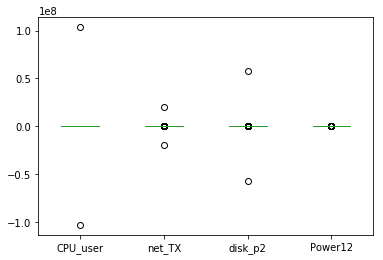

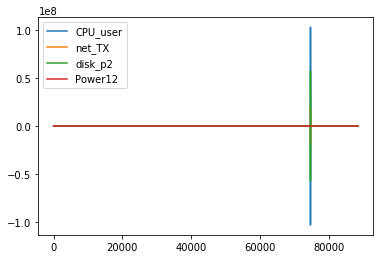

In [8]:
all_data.plot(kind="box")
plotter.show()

#all_data.plot(kind="density")
#plotter.show()

all_data.plot()
plotter.show()

In [9]:
training_set = all_data[:50000]
validation_set = all_data[50000:60000]
testing_set = all_data[60000:]

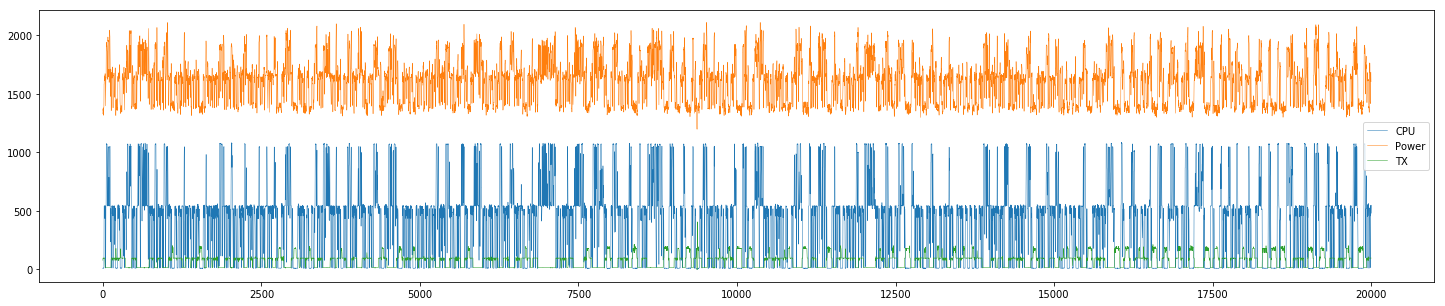

In [10]:
fig = plotter.figure(figsize=(25, 5))
plotter.plot(training_set["CPU_user"][:20000], label="CPU", linewidth=0.5)
plotter.plot(training_set["Power12"][:20000], label="Power", linewidth=0.5)
plotter.plot(training_set["net_TX"][:20000], label="TX", linewidth=0.5)
plotter.legend()
plotter.show()

In [11]:
training_set.head(1000)

CPU_user     net_TX  disk_p2      Power12
0       6.500000  78.000000      0.0  1330.487805
1      11.166667  97.500000      0.0  1358.130081
2      11.666667  97.500000      0.0  1374.390244
3      11.166667  97.500000      0.0  1374.390244
4      11.166667  97.500000      0.0  1358.130081
5      12.333333  97.500000      0.0  1374.390244
6      12.333333  97.500000      0.0  1380.487805
7      11.166667  97.500000      0.0  1380.487805
8      12.333333  97.500000      0.0  1317.886179
9      11.166667  97.500000      0.0  1381.097561
10     11.166667  97.500000      0.0  1381.097561
11     12.333333  97.500000      0.0  1380.487805
12     12.333333  97.500000      0.0  1380.487805
13     12.000000  95.000000      0.0  1381.097561
14     12.000000  97.500000      0.0  1381.097561
15     12.000000  97.500000      0.0  1381.097561
16     12.000000  95.000000      0.0  1390.853659
17     14.000000  97.500000      0.0  1427.235772
18    311.000000  97.500000      0.0  1584.146341
19    481.500000  97.500000      0.0  1584.146341
20    542.333333  97.500000      0.0  1584.146341
21    542.833333  97.500000      0.0  1631.097561
22    542.833333  97.500000      0.0  1646.951220
23    539.333333  97.500000      0.0  1646.951220
24    542.833333  97.500000      0.0  1655.487805
25    539.333333  97.500000      0.0  1646.951220
26    539.333333  97.500000      0.0  1646.951220
27    541.833333  97.500000      0.0  1614.024390
28    541.833333  97.500000      0.0  1614.024390
29    459.000000  96.500000      0.0  1614.024390
..           ...        ...      ...          ...
970  1074.666667  15.000000      0.0  1867.073171
971  1074.833333  15.000000      0.0  1870.121951
972  1074.666667  15.000000      0.0  1905.487805
973  1072.000000  17.666667      0.0  1943.902439
974  1072.000000  17.666667      0.0  1943.902439
975  1071.500000  16.333333      0.0  1943.902439
976  1071.500000  16.333333      0.0  1928.048780
977  1072.000000  16.333333      0.0  1943.902439
978  1071.500000  16.333333      0.0  1928.048780
979   860.000000  16.333333      0.0  1928.048780
980   659.500000  16.333333      0.0  1711.585366
981   544.666667  16.333333      0.0  1671.138211
982   544.666667  17.333333      0.0  1671.138211
983   543.333333  17.333333      0.0  1633.536585
984   543.333333  17.333333      0.0  1633.536585
985   271.000000  17.333333      0.0  1408.536585
986    14.000000  17.000000      0.0  1395.731707
987    14.000000  15.000000      0.0  1374.796748
988    14.000000  15.000000      0.0  1374.796748
989    16.500000  15.000000      0.0  1387.804878
990    18.000000  15.000000      0.0  1387.804878
991   117.500000  15.000000      0.0  1525.609756
992   435.000000  15.000000      0.0  1649.186992
993   542.666667  15.000000      0.0  1651.219512
994   542.666667  15.000000      0.0  1651.219512
995   542.500000  15.000000      0.0  1722.560976
996   542.500000  15.000000      0.0  1722.560976
997   545.000000  15.000000      0.0  1748.780488
998   832.500000  15.000000    810.0  1870.731707
999   846.000000  15.000000    870.0  1951.219512

[1000 rows x 4 columns]

In [12]:
training_set.corr()

CPU_user    net_TX   disk_p2   Power12
CPU_user  1.000000 -0.659445  0.339696  0.947423
net_TX   -0.659445  1.000000 -0.263045 -0.661148
disk_p2   0.339696 -0.263045  1.000000  0.496021
Power12   0.947423 -0.661148  0.496021  1.000000

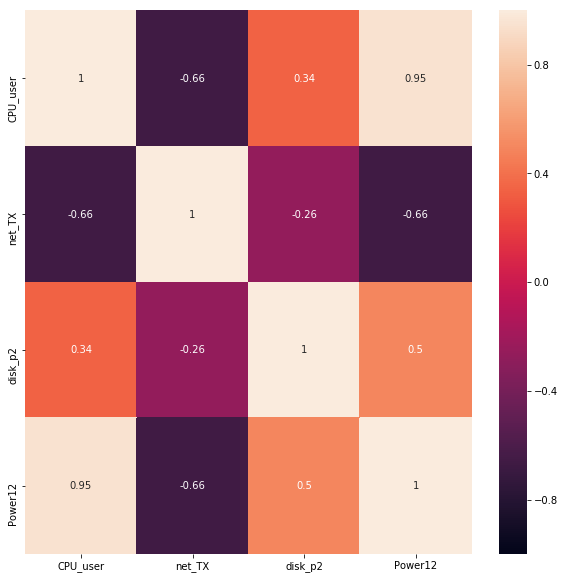

In [13]:
fig = plotter.figure(figsize=(10, 10))
seaborn.heatmap(training_set.corr(), annot=True, vmax=1, vmin=-1)
plotter.savefig("heatmap.png")
plotter.show()

The heatmap shows that the ```CPU_user``` and the ```power12``` features are highly correlated. The ```net_TX``` has a negative correlation. But that is likely true only for this particular application which is running on a single Pi. 

The data will be scaled to between 0 and 1 for the input to the model.

In [14]:
training_set.head(15)

CPU_user  net_TX  disk_p2      Power12
0    6.500000    78.0      0.0  1330.487805
1   11.166667    97.5      0.0  1358.130081
2   11.666667    97.5      0.0  1374.390244
3   11.166667    97.5      0.0  1374.390244
4   11.166667    97.5      0.0  1358.130081
5   12.333333    97.5      0.0  1374.390244
6   12.333333    97.5      0.0  1380.487805
7   11.166667    97.5      0.0  1380.487805
8   12.333333    97.5      0.0  1317.886179
9   11.166667    97.5      0.0  1381.097561
10  11.166667    97.5      0.0  1381.097561
11  12.333333    97.5      0.0  1380.487805
12  12.333333    97.5      0.0  1380.487805
13  12.000000    95.0      0.0  1381.097561
14  12.000000    97.5      0.0  1381.097561

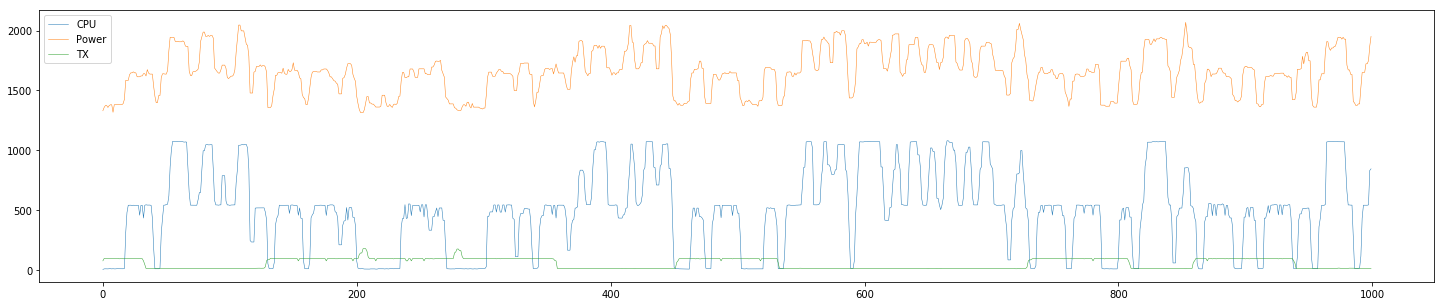

In [15]:
fig = plotter.figure(figsize=(25, 5))
plotter.plot(training_set["CPU_user"][:1000], label="CPU", linewidth=0.5)
plotter.plot(training_set["Power12"][:1000], label="Power", linewidth=0.5)
plotter.plot(training_set["net_TX"][:1000], label="TX", linewidth=0.5)
plotter.legend()
plotter.show()

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
columns = training_set.columns

training_set = pandas.DataFrame(scaler.fit_transform(training_set), columns=columns)
training_set.describe()

CPU_user        net_TX       disk_p2       Power12
count  50000.000000  50000.000000  50000.000000  50000.000000
mean       0.373789      0.184386      0.069463      0.434587
std        0.302933      0.135412      0.145536      0.199491
min        0.000000      0.000000      0.000000      0.000000
25%        0.011974      0.036855      0.000000      0.223945
50%        0.458015      0.239558      0.000000      0.458656
75%        0.488550      0.239558      0.000000      0.537037
max        1.000000      1.000000      1.000000      1.000000

In [17]:
training_set.head(1000)

CPU_user    net_TX   disk_p2   Power12
0    0.005837  0.191646  0.000000  0.138243
1    0.010028  0.239558  0.000000  0.167528
2    0.010477  0.239558  0.000000  0.184755
3    0.010028  0.239558  0.000000  0.184755
4    0.010028  0.239558  0.000000  0.167528
5    0.011076  0.239558  0.000000  0.184755
6    0.011076  0.239558  0.000000  0.191214
7    0.010028  0.239558  0.000000  0.191214
8    0.011076  0.239558  0.000000  0.124892
9    0.010028  0.239558  0.000000  0.191860
10   0.010028  0.239558  0.000000  0.191860
11   0.011076  0.239558  0.000000  0.191214
12   0.011076  0.239558  0.000000  0.191214
13   0.010777  0.233415  0.000000  0.191860
14   0.010777  0.239558  0.000000  0.191860
15   0.010777  0.239558  0.000000  0.191860
16   0.010777  0.233415  0.000000  0.202196
17   0.012573  0.239558  0.000000  0.240741
18   0.279300  0.239558  0.000000  0.406977
19   0.432420  0.239558  0.000000  0.406977
20   0.487053  0.239558  0.000000  0.406977
21   0.487502  0.239558  0.000000  0.456718
22   0.487502  0.239558  0.000000  0.473514
23   0.484359  0.239558  0.000000  0.473514
24   0.487502  0.239558  0.000000  0.482558
25   0.484359  0.239558  0.000000  0.473514
26   0.484359  0.239558  0.000000  0.473514
27   0.486604  0.239558  0.000000  0.438630
28   0.486604  0.239558  0.000000  0.438630
29   0.412214  0.237101  0.000000  0.438630
..        ...       ...       ...       ...
970  0.965125  0.036855  0.000000  0.706718
971  0.965275  0.036855  0.000000  0.709948
972  0.965125  0.036855  0.000000  0.747416
973  0.962730  0.043407  0.000000  0.788114
974  0.962730  0.043407  0.000000  0.788114
975  0.962281  0.040131  0.000000  0.788114
976  0.962281  0.040131  0.000000  0.771318
977  0.962730  0.040131  0.000000  0.788114
978  0.962281  0.040131  0.000000  0.771318
979  0.772339  0.040131  0.000000  0.771318
980  0.592277  0.040131  0.000000  0.541990
981  0.489148  0.040131  0.000000  0.499139
982  0.489148  0.042588  0.000000  0.499139
983  0.487951  0.042588  0.000000  0.459302
984  0.487951  0.042588  0.000000  0.459302
985  0.243377  0.042588  0.000000  0.220930
986  0.012573  0.041769  0.000000  0.207364
987  0.012573  0.036855  0.000000  0.185185
988  0.012573  0.036855  0.000000  0.185185
989  0.014818  0.036855  0.000000  0.198966
990  0.016165  0.036855  0.000000  0.198966
991  0.105523  0.036855  0.000000  0.344961
992  0.390660  0.036855  0.000000  0.475883
993  0.487352  0.036855  0.000000  0.478036
994  0.487352  0.036855  0.000000  0.478036
995  0.487203  0.036855  0.000000  0.553618
996  0.487203  0.036855  0.000000  0.553618
997  0.489448  0.036855  0.000000  0.581395
998  0.747643  0.036855  0.251163  0.710594
999  0.759767  0.036855  0.269767  0.795866

[1000 rows x 4 columns]

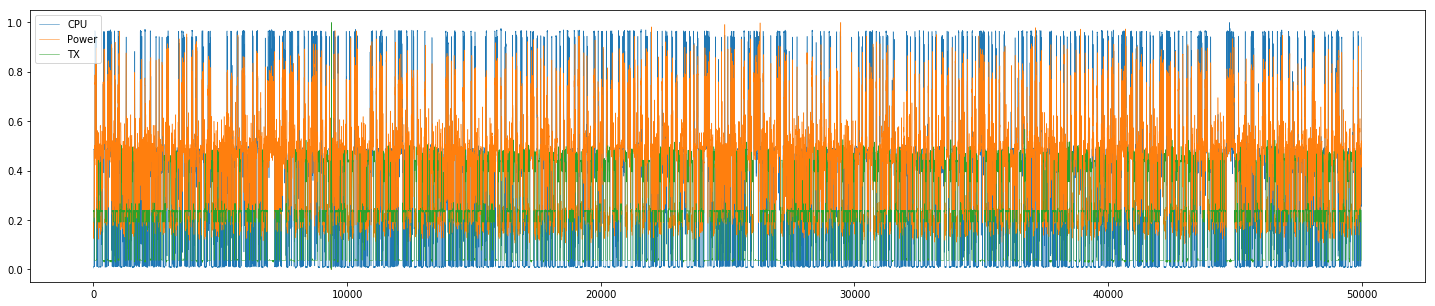

In [18]:
fig = plotter.figure(figsize=(25, 5))
plotter.plot(training_set["CPU_user"], label="CPU", linewidth=0.5)
plotter.plot(training_set["Power12"], label="Power", linewidth=0.5)
plotter.plot(training_set["net_TX"], label="TX", linewidth=0.5)
plotter.legend()
plotter.show()

In [19]:
columns = validation_set.columns

validation_set = pandas.DataFrame(scaler.transform(validation_set.as_matrix()), columns=columns)
validation_set.describe()

CPU_user        net_TX       disk_p2       Power12
count  10000.000000  10000.000000  10000.000000  10000.000000
mean       0.391217      0.173526      0.071008      0.445192
std        0.304066      0.136515      0.145462      0.198274
min        0.007185      0.029484      0.000000      0.107881
25%        0.013022      0.036855      0.000000      0.232989
50%        0.466397      0.237101      0.000000      0.465116
75%        0.488849      0.239558      0.000000      0.549096
max        0.970962      0.529075      0.933850      0.981912

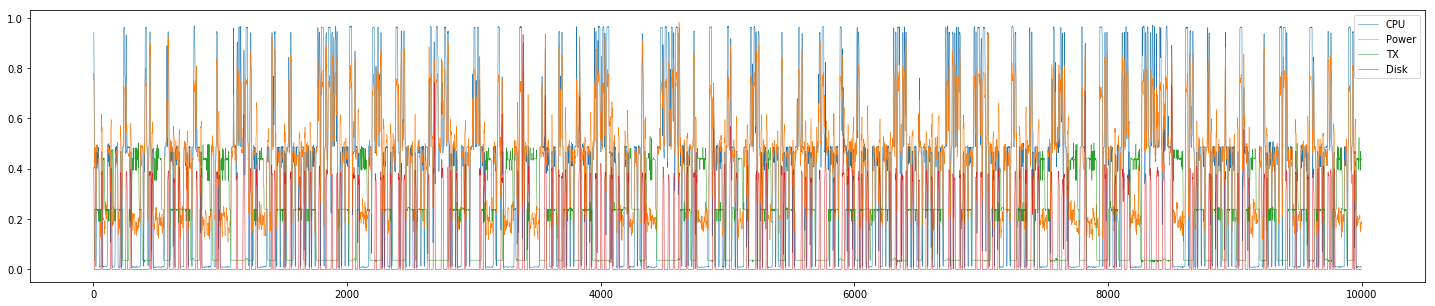

In [20]:
fig = plotter.figure(figsize=(25, 5))
plotter.plot(validation_set["CPU_user"], label="CPU", linewidth=0.5)
plotter.plot(validation_set["Power12"], label="Power", linewidth=0.5)
plotter.plot(validation_set["net_TX"], label="TX", linewidth=0.5)
#plotter.plot(validation_set["net_RX"], label="RX", linewidth=0.5)
plotter.plot(validation_set["disk_p2"], label="Disk", linewidth=0.5)
plotter.legend()
plotter.show()

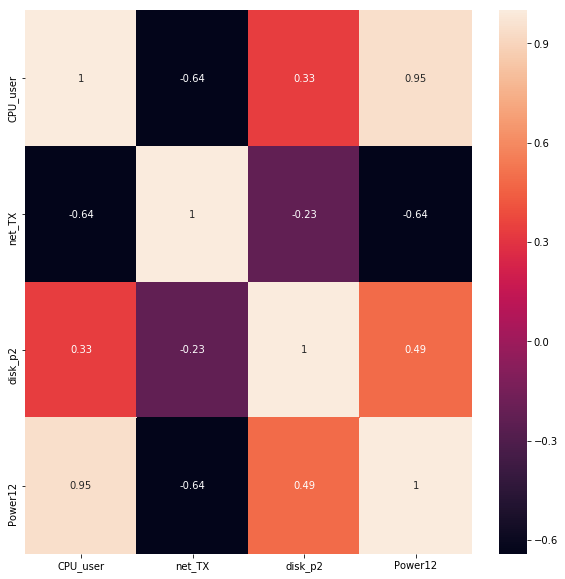

In [21]:
fig = plotter.figure(figsize=(10, 10))
seaborn.heatmap(validation_set.corr(), annot=True)
plotter.show()

### Define dataset handlers and helpers

In [22]:
import numpy

In [23]:
class DataLoader:
    """
        Defines data loader for seq2point model.
    """
    
    def __init__(self, X, y, window=5):
        self.X = X
        self.y = y
        self.window = window
        
    def __len__(self):
        return (self.X.shape[0]-(self.window + 1))
    
    def __getitem__(self, i):
        """
            Returns single batch of data in flat seq2point compatible format.
        """
        X = self.X[i: i+self.window, :]
        # y = self.y[i+int(self.window/2)]
        y = self.y[i+self.window]
        
        return (X, y)


class BatchLoader:
    """
        Creates batches from data provided by dataloader.
    """
    
    def __init__(self, dataloader, batch_size=32):
        self.dloader = dataloader
        self.batch_size = batch_size
        self.samples = list(range(len(self.dloader)))
        
    def __len__(self):
        return int(len(self.dloader)/self.batch_size) - 1
        
    def __getitem__(self, i):
        i = i*self.batch_size
        _samples = self.samples[i: i+self.batch_size]
        
        X=[]
        y=[]
        
        for j in range(len(_samples)):
            _X, _y = self.dloader[_samples[j]]
            X.append(_X.ravel())
            y.append(_y)
        
        return numpy.array(X), numpy.array(y)
    
class ConvBatchLoader:
    """
        Creates conv batches from data provided by dataloader.
    """
    
    def __init__(self, dataloader, batch_size=32):
        self.dloader = dataloader
        self.batch_size = batch_size
        self.samples = list(range(len(self.dloader)))
        
    def __len__(self):
        return int(len(self.dloader)/self.batch_size) - 1
        
    def __getitem__(self, i):
        i = i*self.batch_size
        _samples = self.samples[i: i+self.batch_size]
        
        X=[]
        y=[]
        
        for j in range(len(_samples)):
            _X, _y = self.dloader[_samples[j]]
            X.append(_X)
            y.append(_y)
        
        return numpy.array(X), numpy.array(y)

In [24]:
class DisaggDataLoader:
    """
        Defines data loader for disaggregation model.
    """
    
    def __init__(self, X, y, window=5):
        self.X = X
        self.y = y
        self.window = window
        
    def __len__(self):
        return (self.X.shape[0]-(self.window+1))
    
    def __getitem__(self, i):
        """
            Returns single batch of data in flat seq2point compatible format.
        """
        X = self.X[i: i+self.window]
        cpu_y = self.y.iloc[i+int(self.window/2)]["CPU_user"]
        tx_y = self.y.iloc[i+int(self.window/2)]["net_TX"]
        #rx_y = self.y.iloc[i+int(self.window/2)]["net_RX"]
        disk_y = self.y.iloc[i+int(self.window/2)]["disk_p2"]
        
        return (X, {"cpu": cpu_y, "tx": tx_y, "disk": disk_y})

In [25]:
class DisaggConvBatchLoader:
    """
        Creates conv batches from data provided by dataloader.
    """
    
    def __init__(self, dataloader, batch_size=32):
        self.dloader = dataloader
        self.batch_size = batch_size
        self.samples = list(range(len(self.dloader)))
        
    def __len__(self):
        return int(len(self.dloader)/self.batch_size) - 1
        
    def __getitem__(self, i):
        i = i*self.batch_size
        _samples = self.samples[i: i+self.batch_size]
        
        X=[]
        cpu_y=[]
        rx_y=[]
        tx_y=[]
        disk_y=[]
        
        for j in range(len(_samples)):
            _X, _y = self.dloader[_samples[j]]
            X.append(_X)
            cpu_y.append(_y["cpu"])
            #rx_y.append(_y["rx"])
            tx_y.append(_y["tx"])
            disk_y.append(_y["disk"])
        
        return numpy.array(X), {"cpu": numpy.array(cpu_y), "tx": numpy.array(tx_y), "disk": numpy.array(disk_y)}

The anomaly detection will be done using a thresholding function.

In [26]:
def run_thresholding(data):
        arr = pandas.Series(data)
        mean = 0
        count = 0
        outliers = numpy.zeros_like(arr)
        thres = numpy.zeros_like(arr)
        means = numpy.zeros_like(arr)
        cmeans = arr.expanding().mean()
        std = 0

        # Compute running stats

        m2 = 0
        for i in range(len(arr)):

            if i > 100 and arr[i] > (mean + 6.0 * std):
                outliers[i] = data[i]
                means[i] = mean
                thres[i] = mean + (6.0 * std)
                continue

            count = count + 1
            delta = arr[i] - mean

            mean = mean + (delta/count)
            means[i] = mean

            new_delta = arr[i] - mean
            m2 = m2 + delta * new_delta

            std = numpy.sqrt(m2 / count)

            thres[i] = mean + (6.0 * std)
            
        return thres, outliers

Run CUSUM anomaly detection

In [27]:
def run_CAD(data, start=50, thres=6, plot=0, true=None):

    data = pandas.Series(data)
    running_mean = data.expanding().mean()
    running_std = data.expanding().std()
    alarm = numpy.zeros_like(data)
    _thres = numpy.zeros_like(data)
    s_h = 0
    for i in range(len(data)):
        
        if i < start:
            continue

        mean, std = running_mean[i], running_std[i]
        _thres[i] = thres * std
        val = max(0, s_h + data[i] - mean - std)

        if val > thres * std:
            alarm[i] = 1.0
        else:
            s_h = val

    return _thres, alarm

Define generator for keras models

In [28]:
def data_gen(loader):
    while 1:
        for i in range(len(loader)):
            yield loader[i]

Split the dataset into training, validation and testing set.

### Aggregation Model

In [29]:
from keras.layers import Conv1D, Input, Dense, Flatten, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from sklearn.metrics import mean_absolute_error

/home/adityas/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Prepare training and validation datasets for the aggregation model

Training Set

In [30]:
agg_train_y = training_set["Power12"]
agg_train_X = training_set.drop("Power12", axis=1)
agg_train_loader = ConvBatchLoader(dataloader=DataLoader(X=agg_train_X.as_matrix(), y=agg_train_y.as_matrix(), window=21), batch_size=64)
agg_train_generator = data_gen(agg_train_loader)

Validation Set

In [31]:
agg_val_y = validation_set["Power12"]
agg_val_X = validation_set.drop("Power12", axis=1)
agg_val_loader = ConvBatchLoader(dataloader=DataLoader(X=agg_val_X.as_matrix(), y=agg_val_y.as_matrix(), window=21), batch_size=5000)
agg_val_X, agg_val_y = agg_val_loader[0]

Define Aggregation model

In [32]:
agg_input = Input(shape=(21, 3))
agg_conv = Conv1D(kernel_size=10, filters=20, activation="relu")(agg_input)
#agg_conv = Conv1D(kernel_size=5, filters=10, activation="relu")(agg_conv)
agg_conv = MaxPooling1D(pool_size=2)(agg_conv)
#agg_conv = Conv1D(kernel_size=3, filters=10, activation="relu")(agg_conv)
#agg_conv = MaxPooling1D(pool_size=2)(agg_conv)
agg_conv = Conv1D(kernel_size=3, filters=10, activation="sigmoid")(agg_conv)
agg_flat = Flatten()(agg_conv)
agg_out = Dense(1, activation="sigmoid")(agg_flat)

In [33]:
agg_model = Model(inputs=agg_input, outputs=agg_out)
agg_model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_absolute_error"])

Display aggregation model

In [34]:
plot_model(agg_model, to_file="agg_model.png", show_shapes=True)

<img src="agg_model.png">

Epoch 1/1000
 - 4s - loss: 0.0151 - mean_absolute_error: 0.0956 - val_loss: 0.0082 - val_mean_absolute_error: 0.0705
Epoch 2/1000
 - 2s - loss: 0.0070 - mean_absolute_error: 0.0625 - val_loss: 0.0058 - val_mean_absolute_error: 0.0565
Epoch 3/1000
 - 2s - loss: 0.0059 - mean_absolute_error: 0.0554 - val_loss: 0.0059 - val_mean_absolute_error: 0.0576
Epoch 4/1000
 - 2s - loss: 0.0055 - mean_absolute_error: 0.0531 - val_loss: 0.0051 - val_mean_absolute_error: 0.0517
Epoch 5/1000
 - 2s - loss: 0.0052 - mean_absolute_error: 0.0517 - val_loss: 0.0051 - val_mean_absolute_error: 0.0528
Epoch 6/1000
 - 2s - loss: 0.0051 - mean_absolute_error: 0.0508 - val_loss: 0.0051 - val_mean_absolute_error: 0.0532
Epoch 7/1000
 - 2s - loss: 0.0050 - mean_absolute_error: 0.0503 - val_loss: 0.0046 - val_mean_absolute_error: 0.0488
Epoch 8/1000
 - 2s - loss: 0.0048 - mean_absolute_error: 0.0497 - val_loss: 0.0046 - val_mean_absolute_error: 0.0496
Epoch 9/1000
 - 2s - loss: 0.0047 - mean_absolute_error: 0.0489 

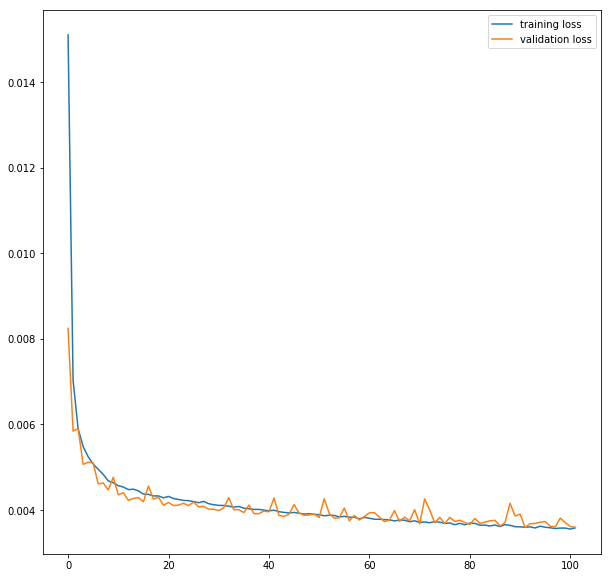

In [35]:
estopper = EarlyStopping(monitor="val_loss", patience=10)
loss = agg_model.fit_generator(callbacks=[estopper], 
                               generator=agg_train_generator, 
                               validation_data=(agg_val_X, agg_val_y), 
                               shuffle=True, 
                               steps_per_epoch=1000, 
                               epochs=1000,
                               verbose=2)

fig = plotter.figure(figsize=(10, 10))
plotter.plot(loss.history["loss"], label="training loss")
plotter.plot(loss.history["val_loss"], label="validation loss")
plotter.legend()
plotter.show()

In [36]:
agg_model.evaluate(x=agg_val_X, y=agg_val_y, verbose=1)

5000/5000 [==============================] - 0s 28us/step


[0.0035964559711515903, 0.04366187087893486]

### Testing aggregation model

predictions


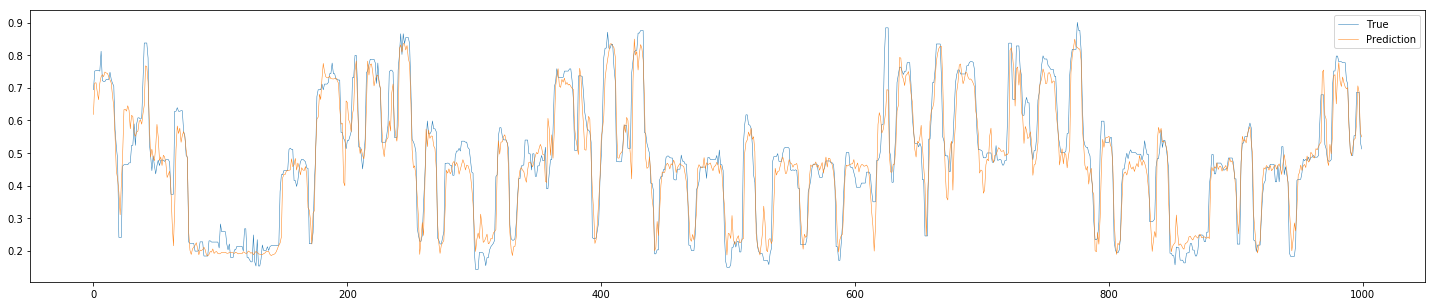

In [37]:
prediction = agg_model.predict(agg_val_X)
print("predictions")
fig = plotter.figure(figsize=(25,5))
plotter.plot(agg_val_y[2000: 3000], linewidth=0.5, label="True")
plotter.plot(prediction[2000: 3000], linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

### Disaggregation model

Prepare training and validation sets for disaggregation model

Training set

In [38]:
disagg_train_X = training_set["Power12"]
disagg_train_y = training_set.drop("Power12", axis=1)
disagg_train_loader = DisaggConvBatchLoader(dataloader=DisaggDataLoader(X=disagg_train_X.as_matrix()[:, numpy.newaxis], 
                                                                        y=disagg_train_y, 
                                                                        window=51), 
                                            batch_size=64)

disagg_train_generator = data_gen(disagg_train_loader)

Validation set

In [39]:
disagg_val_X = validation_set["Power12"]
disagg_val_y = validation_set.drop("Power12", axis=1)
disagg_val_loader = DisaggConvBatchLoader(dataloader=DisaggDataLoader(X=disagg_val_X.as_matrix()[:, numpy.newaxis],
                                                                      y=disagg_val_y, 
                                                                      window=51), 
                                          batch_size=5000)

disagg_val_X, disagg_val_y = disagg_val_loader[0]

Define disaggregation model

In [40]:
disagg_input = Input(shape=(51, 1))
disaggconv = Conv1D(kernel_size=10, filters=40, activation="relu")(disagg_input)
disaggconv = MaxPooling1D(pool_size=2)(disaggconv)
disaggconv = Conv1D(kernel_size=10, filters=40, activation="relu")(disaggconv)

#CPU
disagg_cpu_conv = Conv1D(kernel_size=5, filters=10, activation="relu")(disaggconv)
disagg_cpu_conv = Conv1D(kernel_size=5, filters=10, activation="relu")(disagg_cpu_conv)
disagg_cpu_flat = Flatten()(disagg_cpu_conv)
disagg_cpu_out = Dense(1, activation="sigmoid", name="cpu")(disagg_cpu_flat)

#TX
disagg_tx_conv = Conv1D(kernel_size=5, filters=10, activation="relu")(disaggconv)
disagg_tx_conv = Conv1D(kernel_size=5, filters=10, activation="relu")(disagg_tx_conv)
disagg_tx_flat = Flatten()(disagg_tx_conv)
disagg_tx_out = Dense(1, activation="sigmoid", name="tx")(disagg_tx_flat)

#RX
#disagg_rx_conv = Conv1D(kernel_size=5, filters=10, activation="relu")(disaggconv)
#disagg_rx_conv = Conv1D(kernel_size=5, filters=10, activation="relu")(disagg_rx_conv)
#disagg_rx_flat = Flatten()(disagg_rx_conv)
#disagg_rx_out = Dense(1, activation="sigmoid", name="rx")(disagg_rx_flat)

#Disk
disagg_disk_conv = Conv1D(kernel_size=5, filters=10, activation="relu")(disaggconv)
disagg_disk_conv = Conv1D(kernel_size=5, filters=10, activation="relu")(disagg_disk_conv)
disagg_disk_flat = Flatten()(disagg_disk_conv)
disagg_disk_out = Dense(1, activation="sigmoid", name="disk")(disagg_disk_flat)

In [41]:
disagg_model = Model(inputs=disagg_input, outputs=[disagg_cpu_out, 
                                                   disagg_tx_out, 
                                                   #disagg_rx_out, 
                                                   disagg_disk_out])
disagg_model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_absolute_error"])

Display model

In [42]:
plot_model(disagg_model, to_file="disagg_model.png", show_shapes=True)

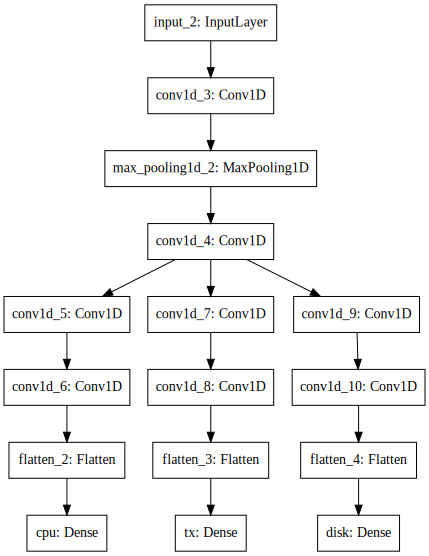

In [43]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(disagg_model).create(prog='dot', format='svg'))

Train model

Epoch 1/1000
 - 21s - loss: 0.0555 - cpu_loss: 0.0271 - tx_loss: 0.0060 - disk_loss: 0.0223 - cpu_mean_absolute_error: 0.1155 - tx_mean_absolute_error: 0.0562 - disk_mean_absolute_error: 0.0871 - val_loss: 0.0225 - val_cpu_loss: 0.0085 - val_tx_loss: 0.0034 - val_disk_loss: 0.0106 - val_cpu_mean_absolute_error: 0.0695 - val_tx_mean_absolute_error: 0.0400 - val_disk_mean_absolute_error: 0.0657
Epoch 2/1000
 - 19s - loss: 0.0207 - cpu_loss: 0.0079 - tx_loss: 0.0032 - disk_loss: 0.0096 - cpu_mean_absolute_error: 0.0651 - tx_mean_absolute_error: 0.0394 - disk_mean_absolute_error: 0.0607 - val_loss: 0.0177 - val_cpu_loss: 0.0070 - val_tx_loss: 0.0030 - val_disk_loss: 0.0077 - val_cpu_mean_absolute_error: 0.0612 - val_tx_mean_absolute_error: 0.0369 - val_disk_mean_absolute_error: 0.0554
Epoch 3/1000
 - 19s - loss: 0.0174 - cpu_loss: 0.0069 - tx_loss: 0.0030 - disk_loss: 0.0074 - cpu_mean_absolute_error: 0.0596 - tx_mean_absolute_error: 0.0375 - disk_mean_absolute_error: 0.0519 - val_loss: 0.

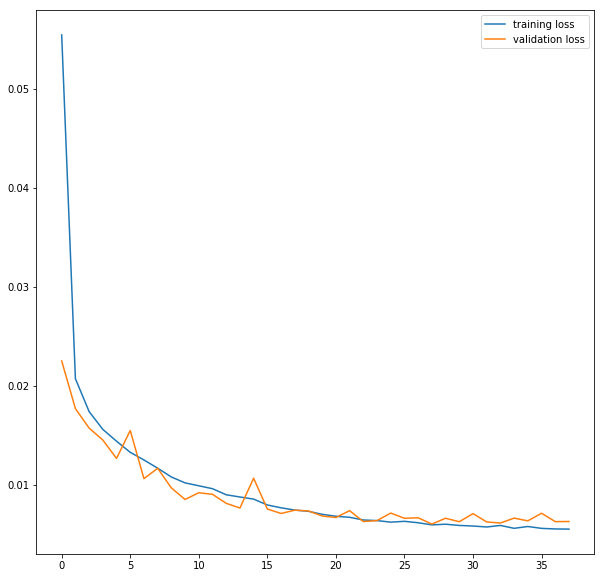

In [44]:
estopper = EarlyStopping(monitor="val_loss", patience=10)
loss = disagg_model.fit_generator(callbacks=[estopper], 
                                  generator=disagg_train_generator, 
                                  validation_data=(disagg_val_X, disagg_val_y), 
                                  shuffle=True, 
                                  steps_per_epoch=1000, 
                                  epochs=1000,
                                  verbose=2)

fig = plotter.figure(figsize=(10, 10))
plotter.plot(loss.history["loss"], label="training loss")
plotter.plot(loss.history["val_loss"], label="validation loss")
plotter.legend()
plotter.show()

In [45]:
disagg_model.evaluate(x=disagg_val_X, y=disagg_val_y, verbose=1)

5000/5000 [==============================] - 0s 81us/step


[0.006286705228872597,
 0.0021617843355095827,
 0.0024381810769904407,
 0.0016867397965759914,
 0.02656351248472929,
 0.030235002192854882,
 0.014066224147081812]

## Test disaggregation model

In [46]:
disagg_val_X = validation_set["Power12"].as_matrix()[:, numpy.newaxis]
disagg_val_y = validation_set.drop("Power12", axis=1)

In [47]:
def make_disagg_prediction(power_X):
    
    cpu_pred = []
    tx_pred = []
    rx_pred = []
    disk_pred = []
    
    for i in range(power_X.shape[0] - 51):
        _inp = power_X[i:i+51][numpy.newaxis,:, numpy.newaxis]
    
        # Disaggregation part
        disagg_predictions = disagg_model.predict(_inp)
    
        cpu_pred.append(disagg_predictions[0].ravel())
        tx_pred.append(disagg_predictions[1].ravel())
        #rx_pred.append(disagg_predictions[2].ravel())
        disk_pred.append(disagg_predictions[2].ravel())
        
    return (numpy.array(cpu_pred), numpy.array(tx_pred), numpy.array(disk_pred))

In [48]:
predictions = make_disagg_prediction(disagg_val_X.ravel())

In [49]:
cpu_pred = predictions[0].ravel()[:2000]
tx_pred = predictions[1].ravel()[:2000]
#rx_pred = predictions[2].ravel()[:2000]
disk_pred = predictions[2].ravel()[:2000]

cpu_true = disagg_val_y["CPU_user"][25:-26].as_matrix()[:2000]
tx_true = disagg_val_y["net_TX"][25:-26].as_matrix()[:2000]
#rx_true = disagg_val_y["net_RX"][25:-26].as_matrix()[:2000]
disk_true = disagg_val_y["disk_p2"][25:-26].as_matrix()[:2000]

CPU


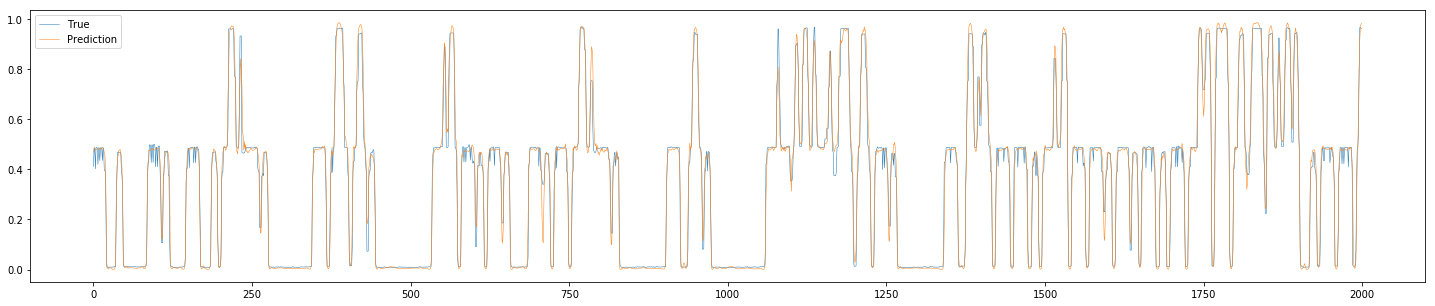

TX


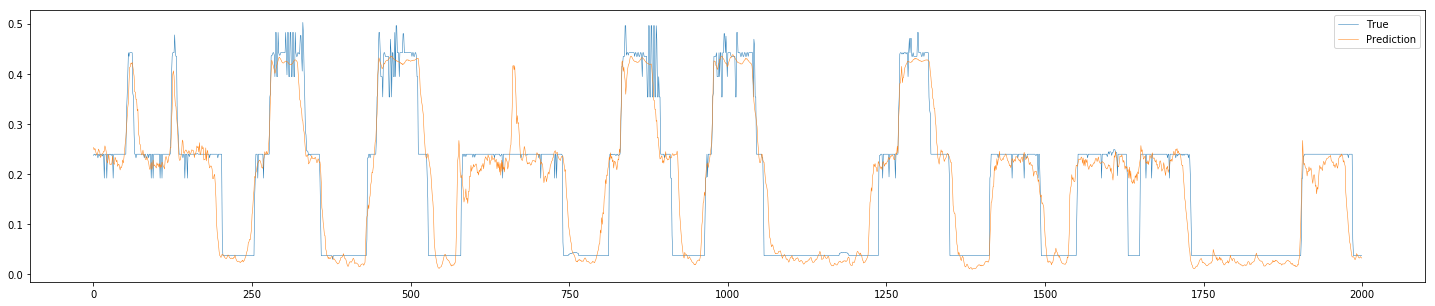

Disk


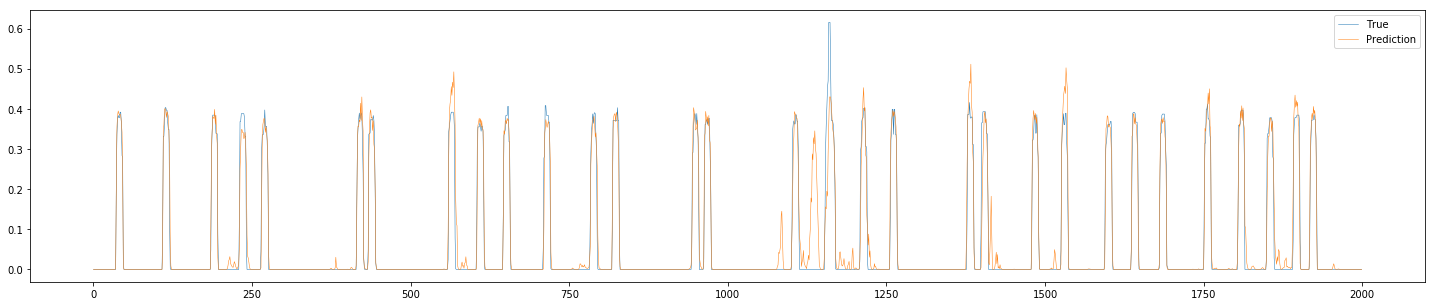

In [50]:
print("CPU")
fig = plotter.figure(figsize=(25,5))
plotter.plot(cpu_true, linewidth=0.5, label="True")
plotter.plot(cpu_pred, linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

print("TX")
fig = plotter.figure(figsize=(25,5))
plotter.plot(tx_true, linewidth=0.5, label="True")
plotter.plot(tx_pred, linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

#print("RX")
#fig = plotter.figure(figsize=(25,5))
#plotter.plot(rx_true, linewidth=0.5, label="True")
#plotter.plot(rx_pred, linewidth=0.5, label="Prediction")
#plotter.legend()
#plotter.show()

print("Disk")
fig = plotter.figure(figsize=(25,5))
plotter.plot(disk_true, linewidth=0.5, label="True")
plotter.plot(disk_pred, linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

------

# System operation

Define the prediction system consisting of the trained aggregation and disaggregation models

In [51]:
def make_prediction(power_X, stats):
    
    cpu_pred = []
    tx_pred = []
    rx_pred = []
    disk_pred = []
    
    stats = stats[25:-26,:]
    
    for i in range(power_X.shape[0] - 51):
        _inp = power_X[i:i+51][numpy.newaxis,:, numpy.newaxis]
    
        # Disaggregation part
        disagg_predictions = disagg_model.predict(_inp)
    
        cpu_pred.append(disagg_predictions[0].ravel())
        tx_pred.append(disagg_predictions[1].ravel())
        #rx_pred.append(disagg_predictions[2].ravel())
        disk_pred.append(disagg_predictions[2].ravel())
    
    data = numpy.vstack([numpy.array(cpu_pred).ravel(),
                         numpy.array(tx_pred).ravel(),
                         #numpy.array(rx_pred).ravel(),
                         numpy.array(disk_pred).ravel()])
    
    data = data.T
    
    diff = numpy.abs(stats - data)

    power_pred = []
    for j in range(data.shape[0] - 21):
        _inp = stats[j:j+21][numpy.newaxis,:,:]

        # Aggregation model
        power_pred.append(agg_model.predict(_inp))
    
    return numpy.array(power_pred).ravel(), diff[51:,:]

In [52]:
columns = testing_set.columns

testing_set = pandas.DataFrame(scaler.transform(testing_set.as_matrix()), columns=columns).clip(lower=0.0, upper=2.0)
testing_set.describe()

CPU_user        net_TX       disk_p2       Power12
count  28560.000000  28560.000000  28560.000000  28560.000000
mean       0.367358      0.201436      0.066954      0.435899
std        0.309036      0.217211      0.144872      0.208302
min        0.000000      0.000000      0.000000      0.000000
25%        0.011226      0.036855      0.000000      0.220284
50%        0.435564      0.239558      0.000000      0.459948
75%        0.489448      0.239558      0.000000      0.551680
max        2.000000      2.000000      2.000000      1.057278

Test on normal behavior

In [53]:
test_norm_X = testing_set["Power12"].as_matrix().ravel()[-5000:]
test_stats = testing_set[["CPU_user", "net_TX", "disk_p2"]].as_matrix()[-5000:]

Make power prediction after disaggregation

In [54]:
power_prediction, all_diff = make_prediction(test_norm_X, test_stats)
print(power_prediction.shape)
print(all_diff.shape)

(4928,)
(4898, 3)


Test plots and differences in prediction of normal data

Normal Behavior


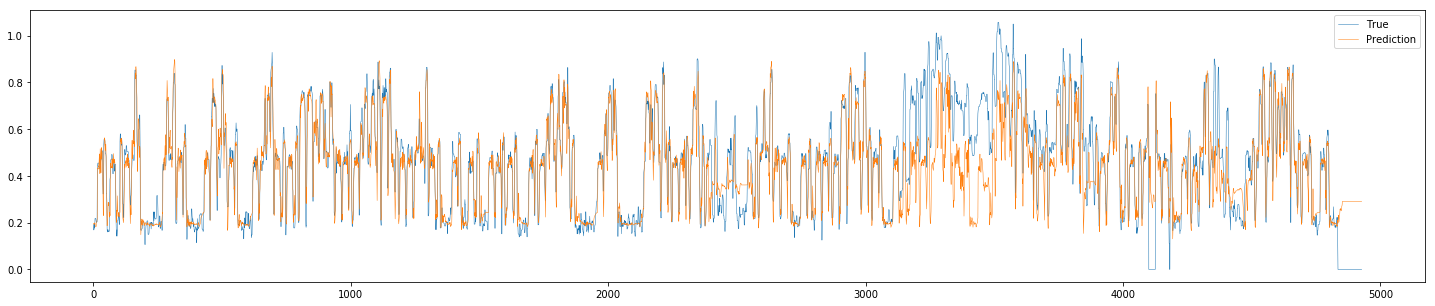

Finer look at first 1000 predictions


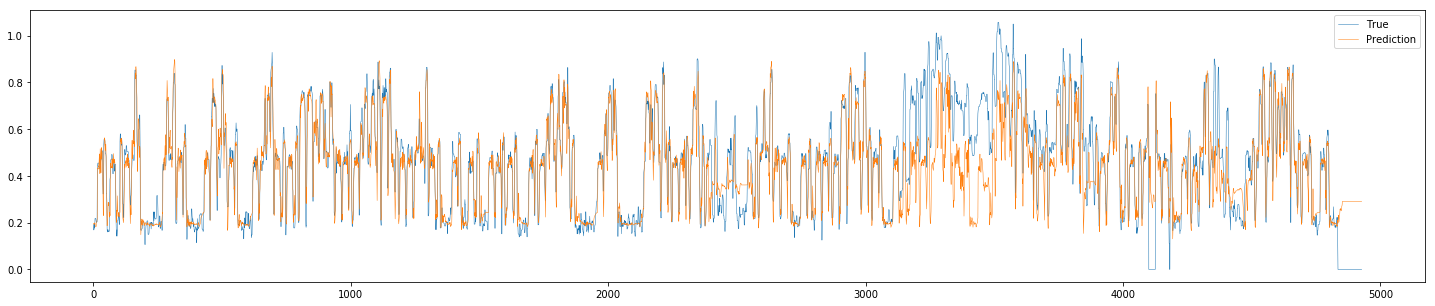

difference


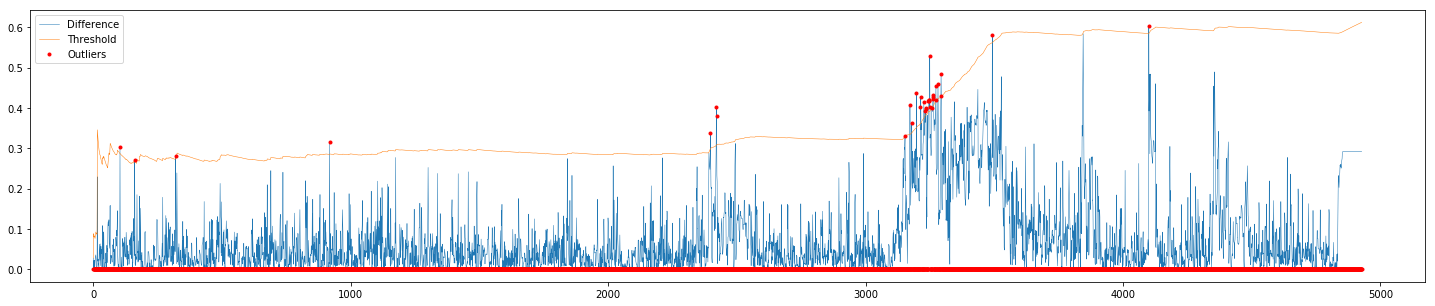

difference
(4928,)


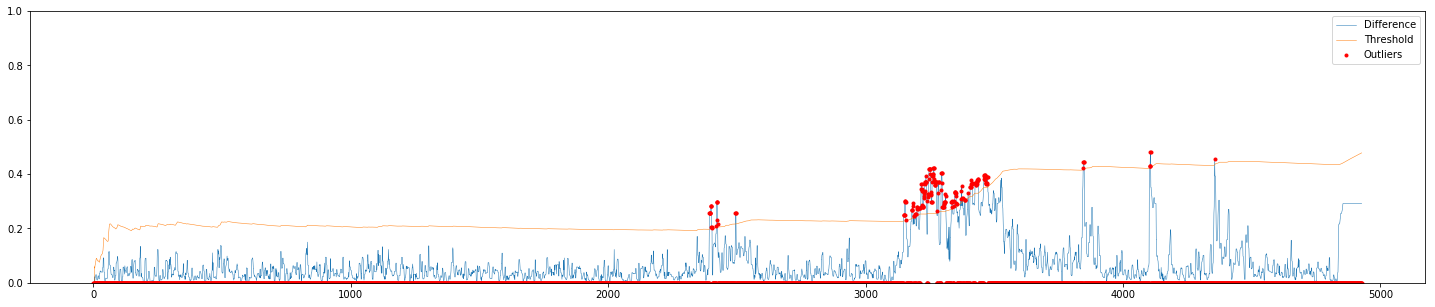

CPU difference


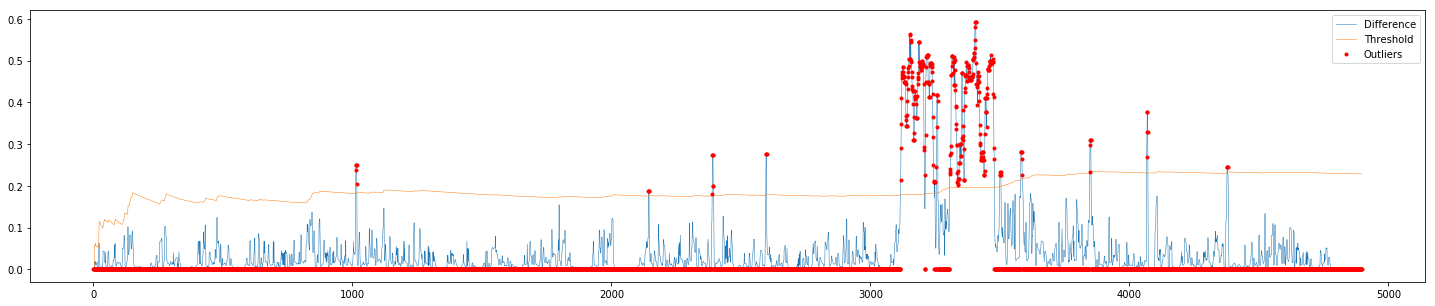

TX difference


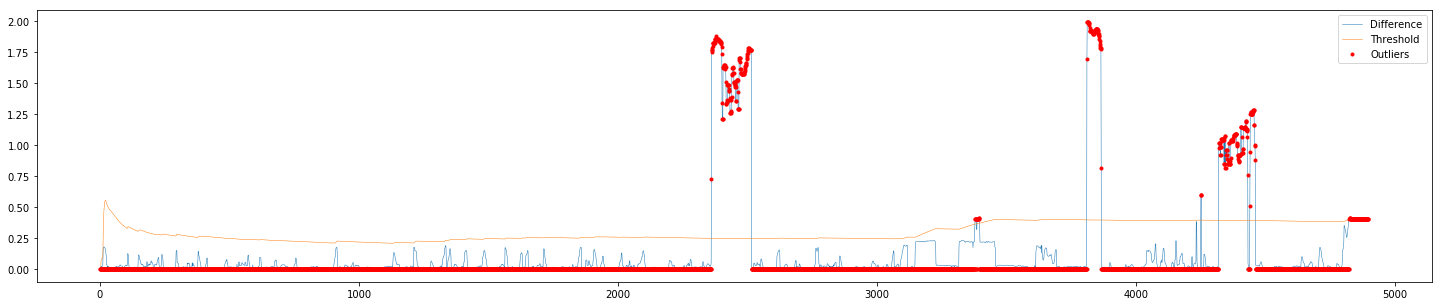

Disk difference


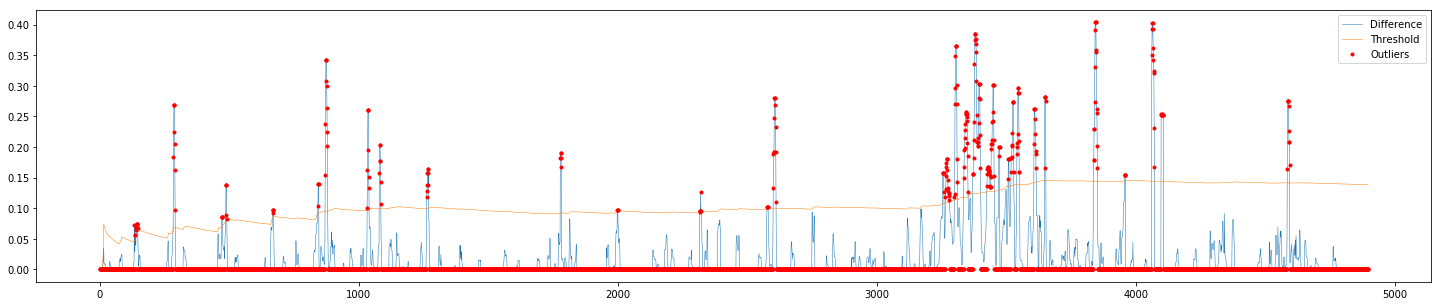

In [55]:
power_input = test_norm_X[46:-26]
net_rx = testing_set["net_TX"].clip(lower=0, upper=1).as_matrix().ravel()[76:-26]
cpu = testing_set["CPU_user"].clip(lower=0, upper=1).as_matrix().ravel()[76:-26]

print("Normal Behavior")
fig = plotter.figure(figsize=(25,5))
plotter.plot(power_input, linewidth=0.5, label="True")
plotter.plot(power_prediction, linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

print("Finer look at first 1000 predictions")
fig = plotter.figure(figsize=(25,5))
plotter.plot(power_input, linewidth=0.5, label="True")
plotter.plot(power_prediction, linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

print("difference")
diff = numpy.abs(power_input - power_prediction)
thres, outliers = run_thresholding(diff)
fig = plotter.figure(figsize=(25,5))
plotter.plot(diff, linewidth=0.5, label="Difference")
plotter.plot(thres, linewidth=0.5, label="Threshold")
plotter.plot(outliers, 'r.', linewidth=0.5, label="Outliers")
#plotter.plot(power_prediction[-1000:], linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

print("difference")
diff = pandas.Series(numpy.abs(power_input - power_prediction)).rolling(5).median().fillna(0)
print(diff.shape)
thres, outliers = run_thresholding(diff.as_matrix().ravel())
fig = plotter.figure(figsize=(25,5))
plotter.plot(diff.as_matrix(), linewidth=0.5, label="Difference")
plotter.plot(thres, linewidth=0.5, label="Threshold")
plotter.plot(outliers, 'r.', linewidth=0.5, label="Outliers")
plotter.ylim(0,1)
plotter.legend()
plotter.show()

cpu_diff = all_diff[:, 0]
tx_diff = all_diff[:, 1]
disk_diff = all_diff[:, 2]

print("CPU difference")
cpu_diff = pandas.Series(cpu_diff).rolling(5).median().fillna(0)
thres, outliers = run_thresholding(cpu_diff)
fig = plotter.figure(figsize=(25,5))
plotter.plot(cpu_diff, linewidth=0.5, label="Difference")
plotter.plot(thres, linewidth=0.5, label="Threshold")
plotter.plot(outliers, 'r.', linewidth=0.5, label="Outliers")
#plotter.plot(power_prediction[-1000:], linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

print("TX difference")
tx_diff = pandas.Series(tx_diff).rolling(5).median().fillna(0)
thres, outliers = run_thresholding(tx_diff)
fig = plotter.figure(figsize=(25,5))
plotter.plot(tx_diff, linewidth=0.5, label="Difference")
plotter.plot(thres, linewidth=0.5, label="Threshold")
plotter.plot(outliers, 'r.', linewidth=0.5, label="Outliers")
#plotter.plot(power_prediction[-1000:], linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

print("Disk difference")
disk_diff = pandas.Series(disk_diff).rolling(5).median().fillna(0)
thres, outliers = run_thresholding(disk_diff)
fig = plotter.figure(figsize=(25,5))
plotter.plot(disk_diff, linewidth=0.5, label="Difference")
plotter.plot(thres, linewidth=0.5, label="Threshold")
plotter.plot(outliers, 'r.', linewidth=0.5, label="Outliers")
#plotter.plot(power_prediction[-1000:], linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()


## Test on attack

In [56]:
data = Path("../data/summer_final_test/")
files = list(data.iterdir())

for file in files:
    print(f"Loading data from {file}")

Loading data from ../data/summer_final_test/summer_final_test_cpu.csv
Loading data from ../data/summer_final_test/summer_final_test_rx.csv
Loading data from ../data/summer_final_test/summer_final_test_disk.csv
Loading data from ../data/summer_final_test/summer_final_test_voltage.csv
Loading data from ../data/summer_final_test/summer_final_test_power.csv
Loading data from ../data/summer_final_test/summer_final_test_tx.csv


In [57]:
disk = pandas.read_csv(str(data/"summer_final_test_disk.csv")).drop("Unnamed: 0", axis=1)
cpu = pandas.read_csv(str(data/"summer_final_test_cpu.csv")).drop("Unnamed: 0", axis=1)
power = pandas.read_csv(str(data/"summer_final_test_power.csv")).drop("Unnamed: 0", axis=1)
tx = pandas.read_csv(str(data/"summer_final_test_tx.csv")).drop("Unnamed: 0", axis=1)
rx = pandas.read_csv(str(data/"summer_final_test_rx.csv")).drop("Unnamed: 0", axis=1)

A lot of problems in life can be solved using preprocessing. In this case, we'll try median filtering to remove noise from the power signal

Filtering power
Before filtering


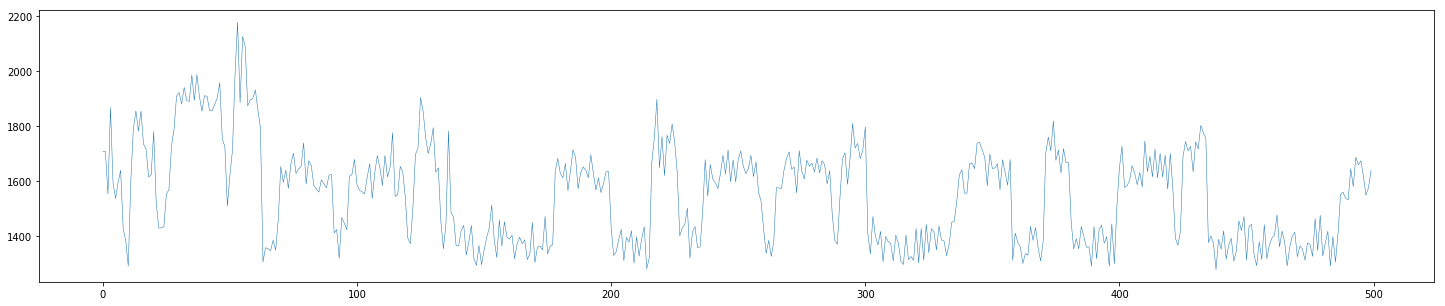

After filtering


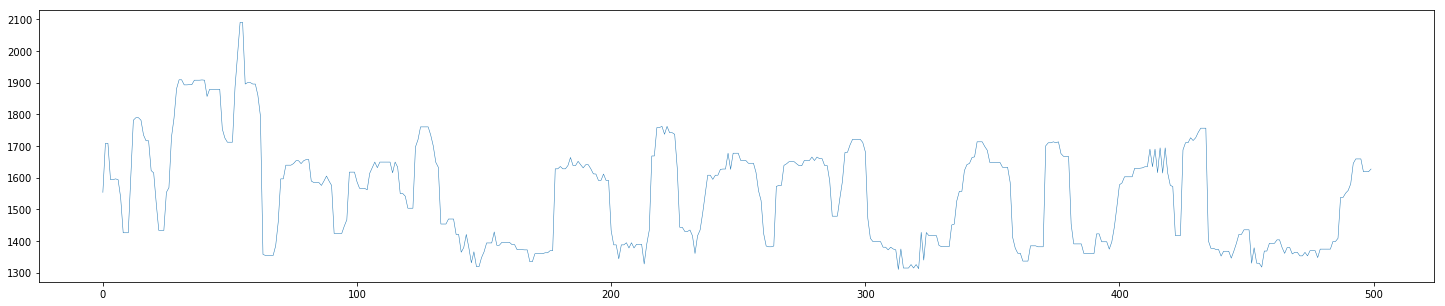

Filtering CPU
Before filtering


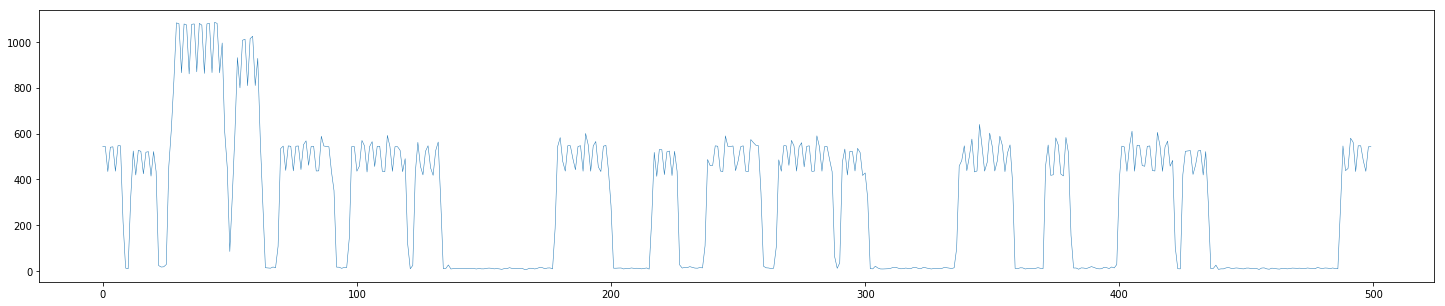

After filtering


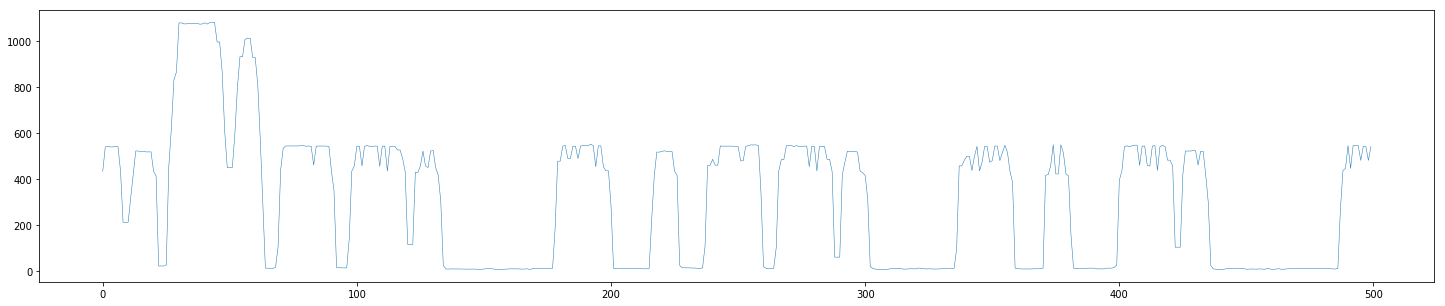

Filtering TX
Before filtering


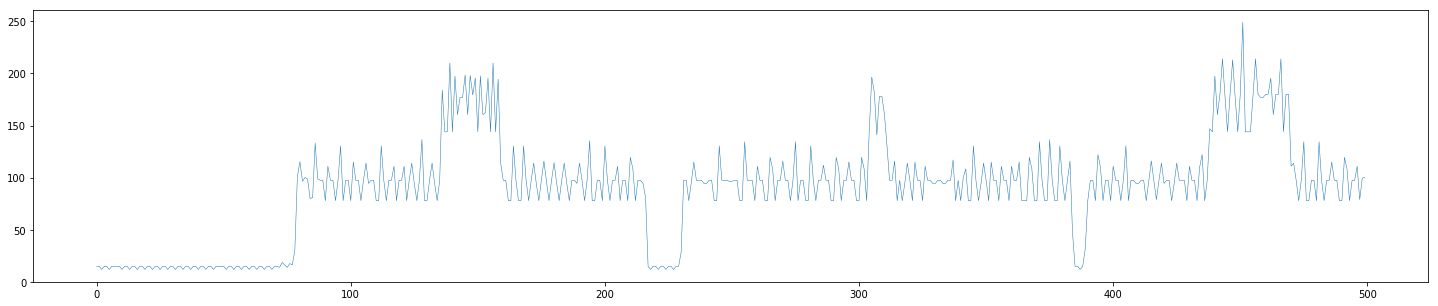

After filtering


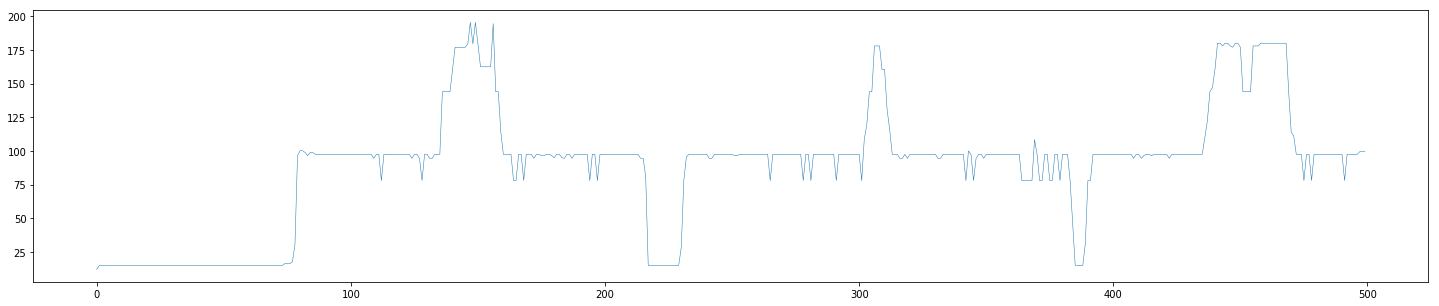

Filtering RX
Before filtering


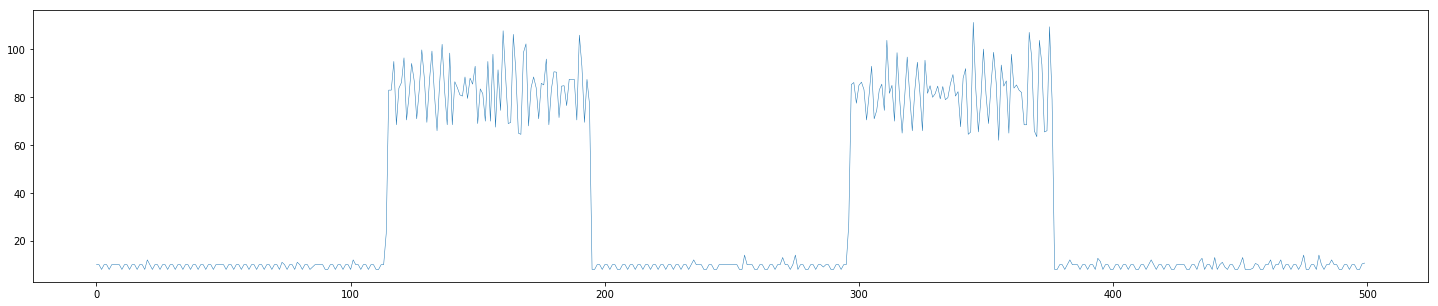

After filtering


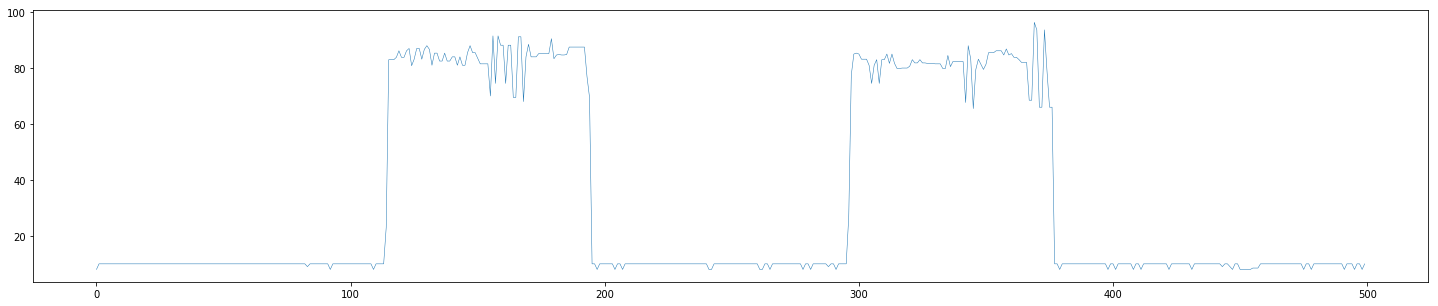

Filtering Disk
Before filtering


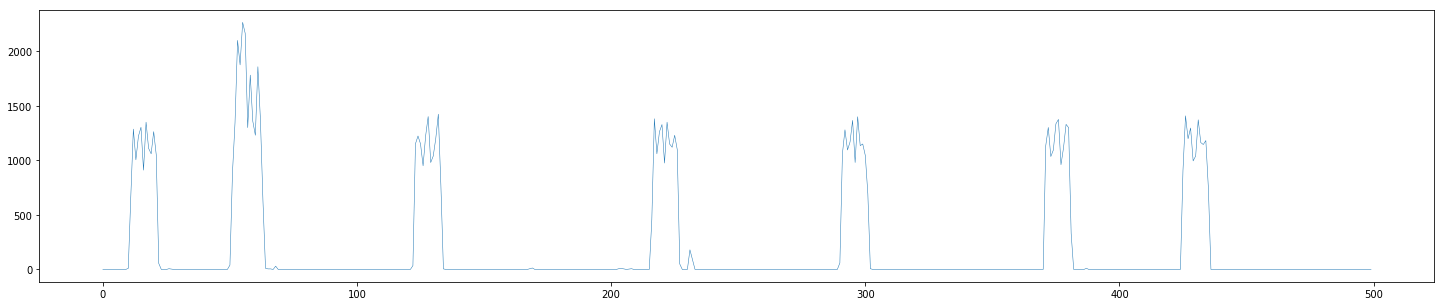

After filtering


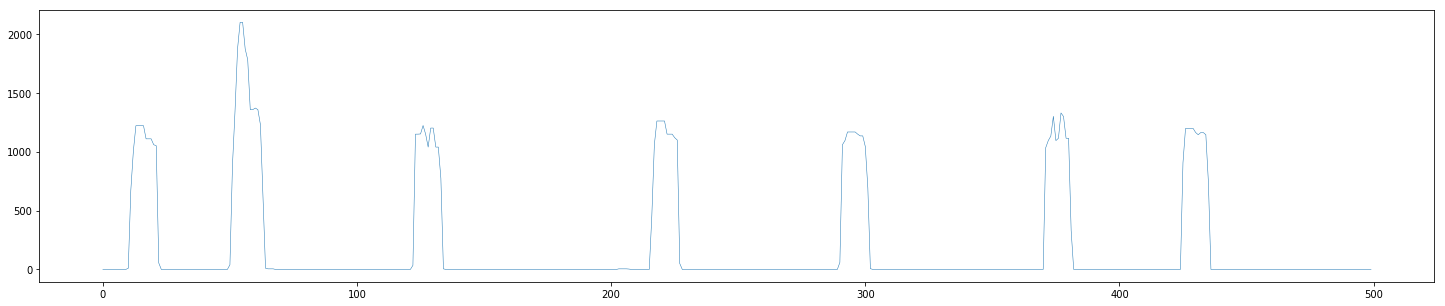

In [58]:
from scipy.signal import medfilt

print("Filtering power")
print("Before filtering")
fig = plotter.figure(figsize=(25, 5))
plotter.plot(power["Power12"].as_matrix().ravel()[0: 500], linewidth=0.5, label="Before filtering")
plotter.show()

print("After filtering")
power = pandas.DataFrame({"Power12": medfilt(power["Power12"].as_matrix().ravel(), kernel_size=5)})
fig = plotter.figure(figsize=(25, 5))
plotter.plot(power["Power12"].as_matrix().ravel()[0: 500], linewidth=0.5, label="Before filtering")
plotter.show()

print("Filtering CPU")
print("Before filtering")
fig = plotter.figure(figsize=(25, 5))
plotter.plot(cpu["CPU_user"].as_matrix().ravel()[0: 500], linewidth=0.5, label="Before filtering")
plotter.show()

print("After filtering")
cpu = pandas.DataFrame({"CPU_user": medfilt(cpu["CPU_user"].as_matrix().ravel(), kernel_size=5)})
fig = plotter.figure(figsize=(25, 5))
plotter.plot(cpu["CPU_user"].as_matrix().ravel()[0: 500], linewidth=0.5, label="Before filtering")
plotter.show()

print("Filtering TX")
print("Before filtering")
fig = plotter.figure(figsize=(25, 5))
plotter.plot(tx["net_TX"].as_matrix().ravel()[0: 500], linewidth=0.5, label="Before filtering")
plotter.show()

print("After filtering")
tx = pandas.DataFrame({"net_TX": medfilt(tx["net_TX"].as_matrix().ravel(), kernel_size=5)})
fig = plotter.figure(figsize=(25, 5))
plotter.plot(tx["net_TX"].as_matrix().ravel()[0: 500], linewidth=0.5, label="Before filtering")
plotter.show()

print("Filtering RX")
print("Before filtering")
fig = plotter.figure(figsize=(25, 5))
plotter.plot(rx["net_RX"].as_matrix().ravel()[0: 500], linewidth=0.5, label="Before filtering")
plotter.show()

print("After filtering")
rx = pandas.DataFrame({"net_RX": medfilt(rx["net_RX"].as_matrix().ravel(), kernel_size=5)})
fig = plotter.figure(figsize=(25, 5))
plotter.plot(rx["net_RX"].as_matrix().ravel()[0: 500], linewidth=0.5, label="Before filtering")
plotter.show()

print("Filtering Disk")
print("Before filtering")
fig = plotter.figure(figsize=(25, 5))
plotter.plot(disk["disk_p2"].as_matrix().ravel()[0: 500], linewidth=0.5, label="Before filtering")
plotter.show()

print("After filtering")
disk = pandas.DataFrame({"disk_p2": medfilt(disk["disk_p2"].as_matrix().ravel(), kernel_size=5)})
fig = plotter.figure(figsize=(25, 5))
plotter.plot(disk["disk_p2"].as_matrix().ravel()[0: 500], linewidth=0.5, label="Before filtering")
plotter.show()

Combine all dataframes into a single dataset

In [59]:
test_data = pandas.concat([cpu, tx, disk, power.clip(lower=1200)], axis=1, join="inner").fillna(method="ffill").fillna(0)
test_data.describe()

CPU_user       net_TX      disk_p2      Power12
count  3600.000000  3600.000000  3600.000000  3600.000000
mean    475.011157   175.322083   213.591667  1776.789295
std     345.819572   351.424305   447.864776   295.068487
min       8.000000    12.000000     0.000000  1310.162602
25%      62.000000    15.000000     0.000000  1575.609756
50%     512.166667    96.500000     0.000000  1704.878049
75%     573.500000    97.500000     0.000000  1954.878049
max    1153.333333  2158.333333  2686.666667  2626.829268

In [60]:
columns = test_data.columns

test_data = pandas.DataFrame(scaler.transform(test_data.as_matrix()), columns=columns).clip(lower=0.0, upper=2.0)
test_data.describe()

CPU_user       net_TX      disk_p2      Power12
count  3600.000000  3600.000000  3600.000000  3600.000000
mean      0.426593     0.340756     0.066230     0.611069
std       0.310570     0.548255     0.138873     0.312605
min       0.007185     0.029484     0.000000     0.116710
25%       0.055680     0.036855     0.000000     0.397933
50%       0.459961     0.237101     0.000000     0.534884
75%       0.515043     0.239558     0.000000     0.799742
max       1.035773     2.000000     0.833075     1.511628

Test on abnormal behavior

In [61]:
test_X = test_data["Power12"].as_matrix().ravel()
test_stats = test_data[["CPU_user", "net_TX", "disk_p2"]].as_matrix()

Make power prediction after disaggregation

In [62]:
power_prediction, all_diff = make_prediction(test_X, test_stats)
print(power_prediction.shape)
print(all_diff.shape)

(3528,)
(3498, 3)


Test plots and differences in prediction of normal data

Normal Behavior


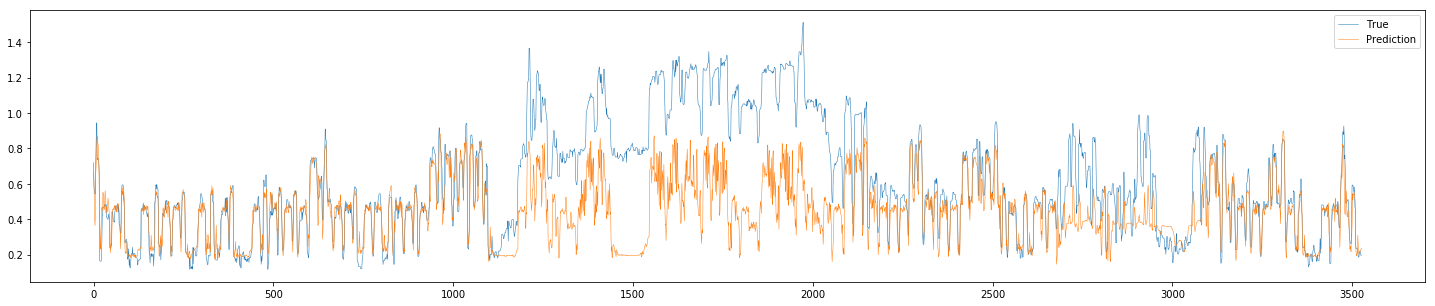

Finer look at first 1000 predictions


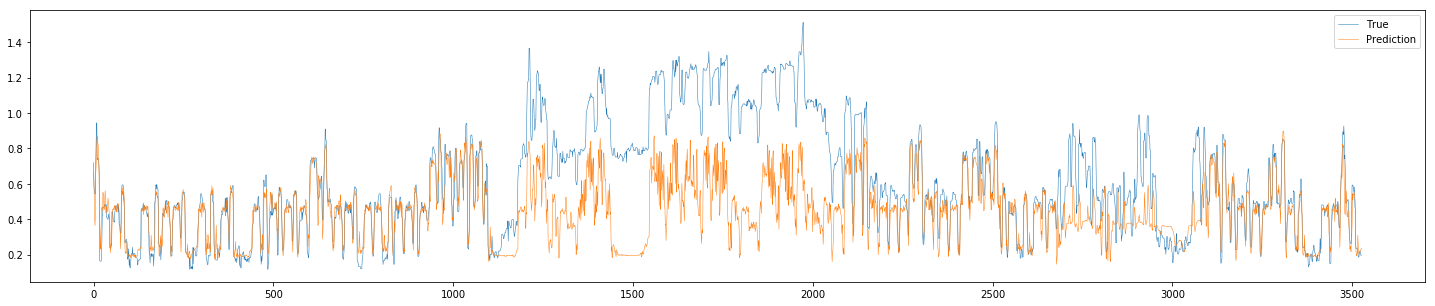

difference


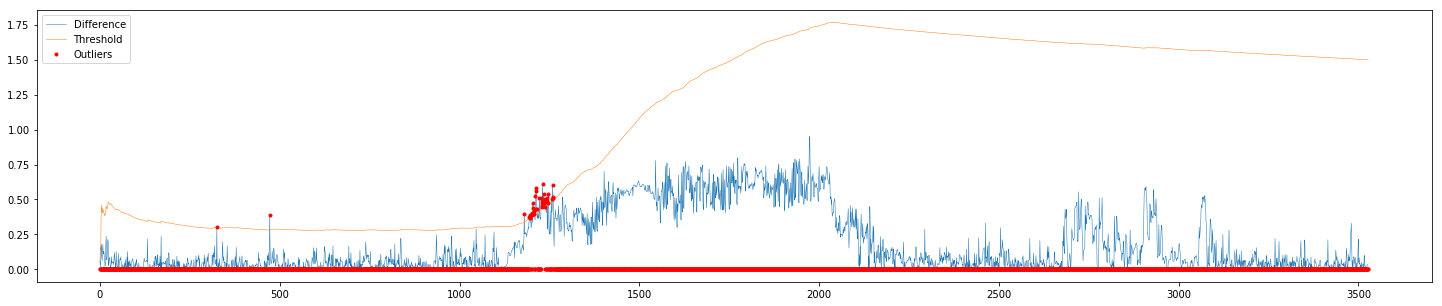

difference
(3528,)


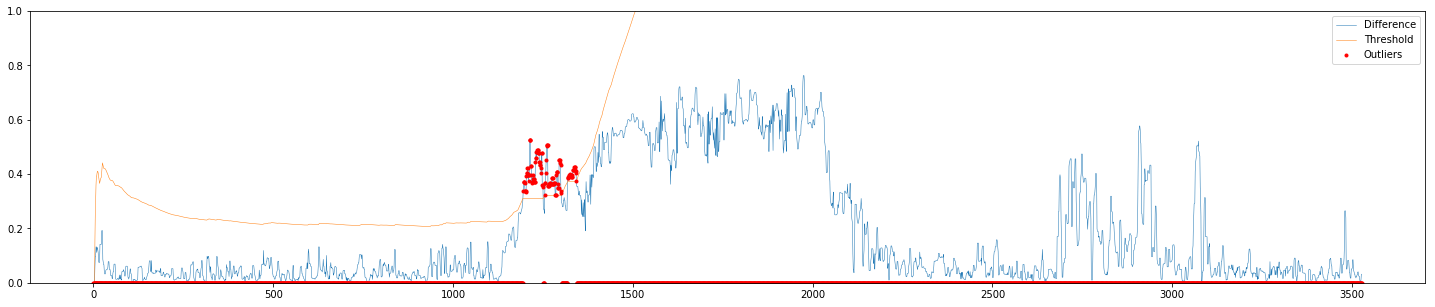

CPU difference


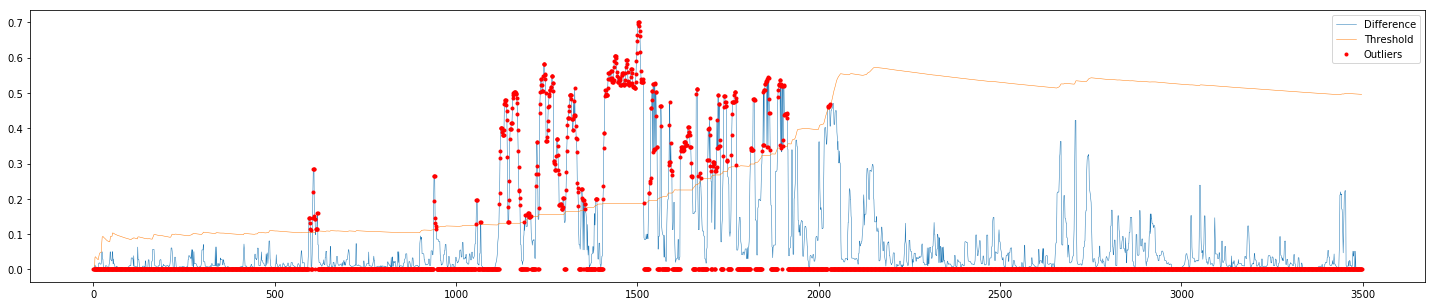

TX difference


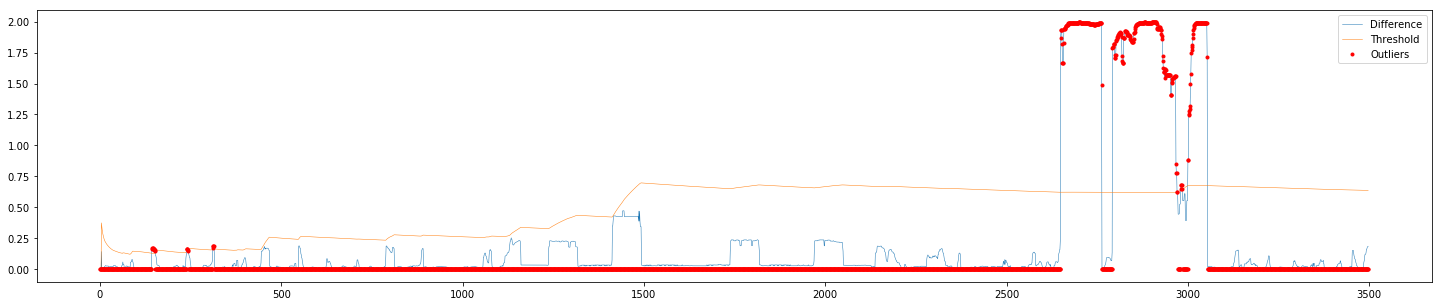

Disk difference


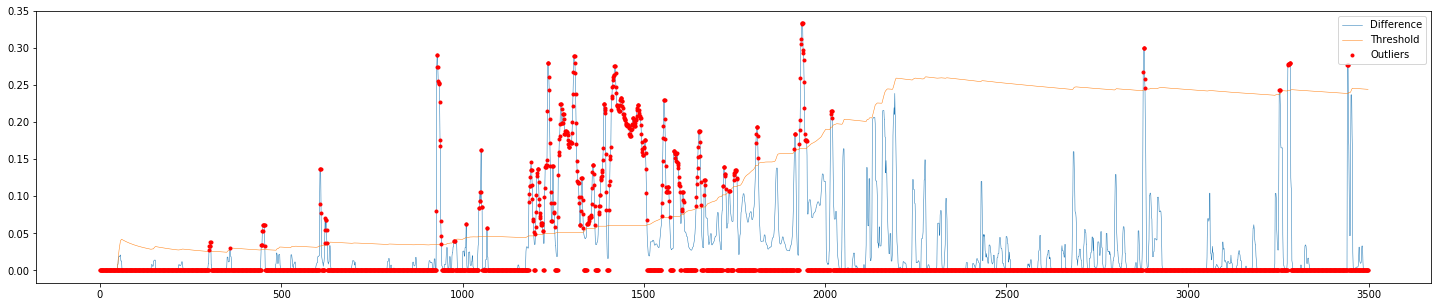

In [63]:
power_input = test_X[46:-26]
net_rx = test_data["net_TX"].clip(lower=0, upper=1).as_matrix().ravel()[76:-26]
cpu = test_data["CPU_user"].clip(lower=0, upper=1).as_matrix().ravel()[76:-26]

print("Normal Behavior")
fig = plotter.figure(figsize=(25,5))
plotter.plot(power_input, linewidth=0.5, label="True")
plotter.plot(power_prediction, linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

print("Finer look at first 1000 predictions")
fig = plotter.figure(figsize=(25,5))
plotter.plot(power_input, linewidth=0.5, label="True")
plotter.plot(power_prediction, linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

print("difference")
diff = numpy.abs(power_input - power_prediction)
thres, outliers = run_thresholding(diff)
fig = plotter.figure(figsize=(25,5))
plotter.plot(diff, linewidth=0.5, label="Difference")
plotter.plot(thres, linewidth=0.5, label="Threshold")
plotter.plot(outliers, 'r.', linewidth=0.5, label="Outliers")
#plotter.plot(power_prediction[-1000:], linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

print("difference")
diff = pandas.Series(numpy.abs(power_input - power_prediction)).rolling(5).median().fillna(0)
print(diff.shape)
thres, outliers = run_thresholding(diff.as_matrix().ravel())
fig = plotter.figure(figsize=(25,5))
plotter.plot(diff.as_matrix(), linewidth=0.5, label="Difference")
plotter.plot(thres, linewidth=0.5, label="Threshold")
plotter.plot(outliers, 'r.', linewidth=0.5, label="Outliers")
plotter.ylim(0,1)
plotter.legend()
plotter.show()

cpu_diff = all_diff[:, 0]
tx_diff = all_diff[:, 1]
disk_diff = all_diff[:, 2]

print("CPU difference")
cpu_diff = pandas.Series(cpu_diff).rolling(5).median().fillna(0)
thres, outliers = run_thresholding(cpu_diff)
fig = plotter.figure(figsize=(25,5))
plotter.plot(cpu_diff, linewidth=0.5, label="Difference")
plotter.plot(thres, linewidth=0.5, label="Threshold")
plotter.plot(outliers, 'r.', linewidth=0.5, label="Outliers")
#plotter.plot(power_prediction[-1000:], linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

print("TX difference")
tx_diff = pandas.Series(tx_diff).rolling(5).median().fillna(0)
thres, outliers = run_thresholding(tx_diff)
fig = plotter.figure(figsize=(25,5))
plotter.plot(tx_diff, linewidth=0.5, label="Difference")
plotter.plot(thres, linewidth=0.5, label="Threshold")
plotter.plot(outliers, 'r.', linewidth=0.5, label="Outliers")
#plotter.plot(power_prediction[-1000:], linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

print("Disk difference")
disk_diff = pandas.Series(disk_diff).rolling(5).median().fillna(0)
thres, outliers = run_thresholding(disk_diff)
fig = plotter.figure(figsize=(25,5))
plotter.plot(disk_diff, linewidth=0.5, label="Difference")
plotter.plot(thres, linewidth=0.5, label="Threshold")
plotter.plot(outliers, 'r.', linewidth=0.5, label="Outliers")
#plotter.plot(power_prediction[-1000:], linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()


Run CUSUM

Normal Behavior


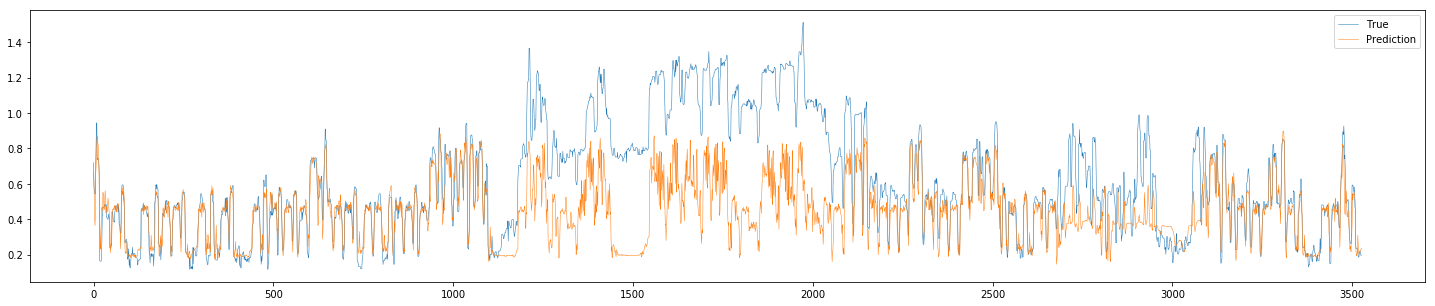

Finer look at first 1000 predictions


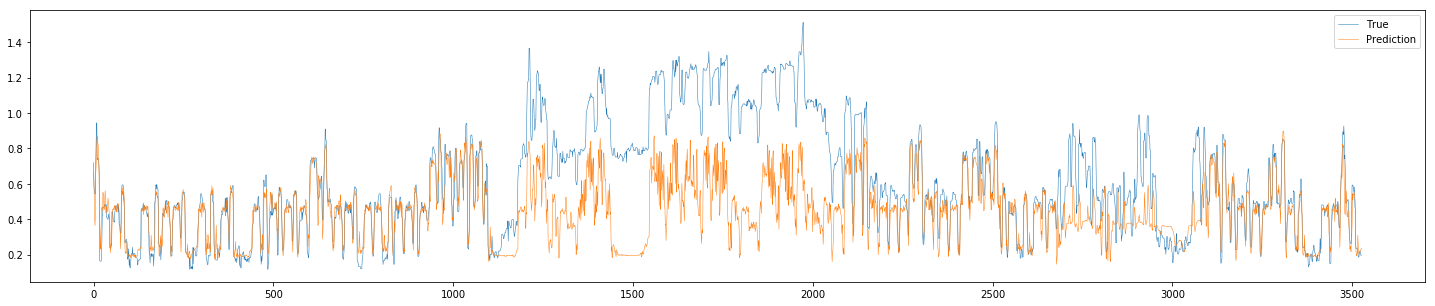

difference


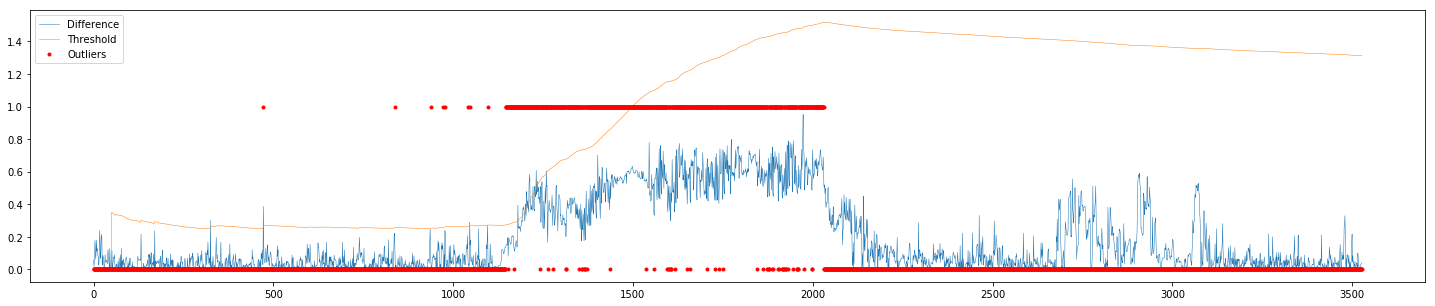

difference
(3528,)


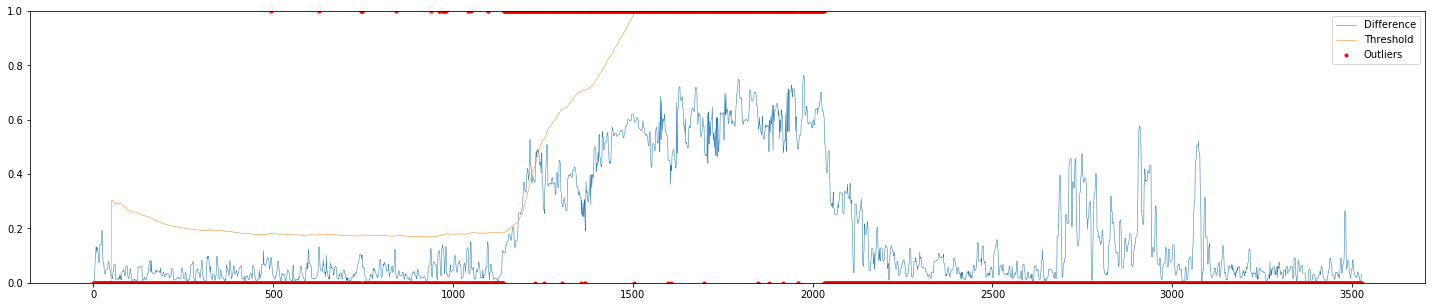

CPU difference


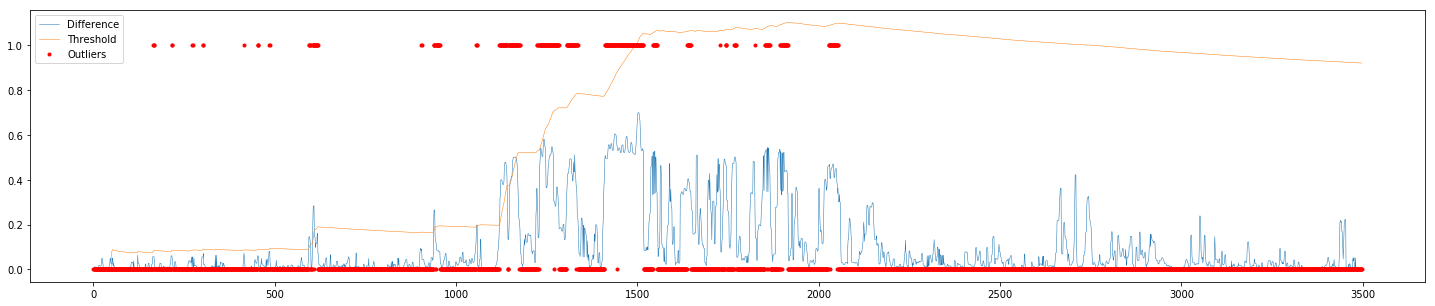

TX difference


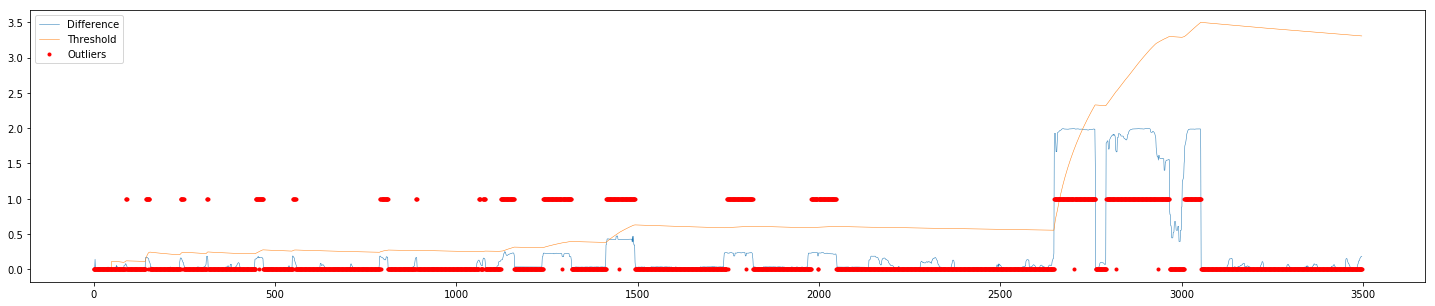

Disk difference


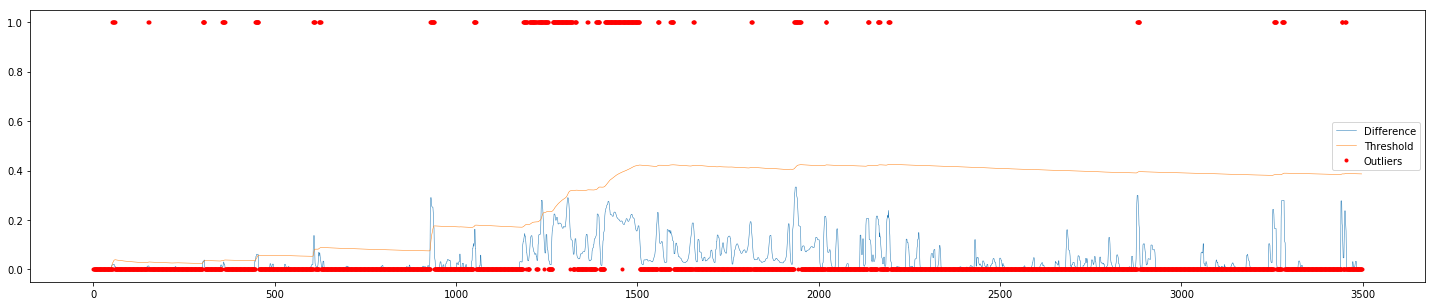

In [64]:
power_input = test_X[46:-26]
net_rx = test_data["net_TX"].clip(lower=0, upper=1).as_matrix().ravel()[76:-26]
cpu = test_data["CPU_user"].clip(lower=0, upper=1).as_matrix().ravel()[76:-26]

print("Normal Behavior")
fig = plotter.figure(figsize=(25,5))
plotter.plot(power_input, linewidth=0.5, label="True")
plotter.plot(power_prediction, linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

print("Finer look at first 1000 predictions")
fig = plotter.figure(figsize=(25,5))
plotter.plot(power_input, linewidth=0.5, label="True")
plotter.plot(power_prediction, linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

print("difference")
diff = numpy.abs(power_input - power_prediction)
thres, outliers = run_CAD(diff)
fig = plotter.figure(figsize=(25,5))
plotter.plot(diff, linewidth=0.5, label="Difference")
plotter.plot(thres, linewidth=0.5, label="Threshold")
plotter.plot(outliers, 'r.', linewidth=0.5, label="Outliers")
#plotter.plot(power_prediction[-1000:], linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

print("difference")
diff = pandas.Series(numpy.abs(power_input - power_prediction)).rolling(5).median().fillna(0)
print(diff.shape)
thres, outliers = run_CAD(diff.as_matrix().ravel())
fig = plotter.figure(figsize=(25,5))
plotter.plot(diff.as_matrix(), linewidth=0.5, label="Difference")
plotter.plot(thres, linewidth=0.5, label="Threshold")
plotter.plot(outliers, 'r.', linewidth=0.5, label="Outliers")
plotter.ylim(0,1)
plotter.legend()
plotter.show()

cpu_diff = all_diff[:, 0]
tx_diff = all_diff[:, 1]
disk_diff = all_diff[:, 2]

print("CPU difference")
cpu_diff = pandas.Series(cpu_diff).rolling(5).median().fillna(0)
thres, outliers = run_CAD(cpu_diff)
fig = plotter.figure(figsize=(25,5))
plotter.plot(cpu_diff, linewidth=0.5, label="Difference")
plotter.plot(thres, linewidth=0.5, label="Threshold")
plotter.plot(outliers, 'r.', linewidth=0.5, label="Outliers")
#plotter.plot(power_prediction[-1000:], linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

print("TX difference")
tx_diff = pandas.Series(tx_diff).rolling(5).median().fillna(0)
thres, outliers = run_CAD(tx_diff)
fig = plotter.figure(figsize=(25,5))
plotter.plot(tx_diff, linewidth=0.5, label="Difference")
plotter.plot(thres, linewidth=0.5, label="Threshold")
plotter.plot(outliers, 'r.', linewidth=0.5, label="Outliers")
#plotter.plot(power_prediction[-1000:], linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

print("Disk difference")
disk_diff = pandas.Series(disk_diff).rolling(5).median().fillna(0)
thres, outliers = run_CAD(disk_diff)
fig = plotter.figure(figsize=(25,5))
plotter.plot(disk_diff, linewidth=0.5, label="Difference")
plotter.plot(thres, linewidth=0.5, label="Threshold")
plotter.plot(outliers, 'r.', linewidth=0.5, label="Outliers")
#plotter.plot(power_prediction[-1000:], linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()
